# XGBoost Multi-class Classification

## Import des librairies et du dataset

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import graphviz

import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced

In [2]:
# Chargement des données
fichier = "/Users/matthieuclaudel/Documents/dataset/projet_ds/data_cleaned_final_sans_dummies.csv"
df = pd.read_csv(fichier, index_col=0, low_memory=False)
df.head()

jour  mois    an  lum dep  agg  int  atm  col        lat  ...  eq_ceinture  \
0    30    11  2019  2.0  93    0  0.0  0.0  2.0  48.896210  ...            1   
1    30    11  2019  2.0  93    0  0.0  0.0  2.0  48.896210  ...            1   
2    30    11  2019  2.0  93    0  0.0  0.0  2.0  48.896210  ...            1   
3    30    11  2019  2.0  93    0  0.0  0.0  6.0  48.930700  ...            1   
4    28    11  2019  0.0  92    0  0.0  0.0  4.0  48.935872  ...            1   

   eq_casque  eq_siege  eq_gilet  eq_airbag  eq_gants  eq_indetermine  \
0          0         0         0          0         0               0   
1          0         0         0          0         0               0   
2          0         0         0          0         0               0   
3          0         0         0          0         0               0   
4          0         0         0          0         0               0   

   eq_autre  jour_chome  prox_pt_choc  
0         0           1             0  
1         0           1             0  
2         0           1             1  
3         0           1             1  
4         0           1             1  

[5 rows x 41 columns]

In [3]:
df.shape

(447136, 41)

In [4]:
df.columns

Index(['jour', 'mois', 'an', 'lum', 'dep', 'agg', 'int', 'atm', 'col', 'lat',
       'long', 'catr', 'circ', 'prof', 'plan', 'surf', 'infra', 'situ', 'grav',
       'sexe', 'catv', 'obs', 'obsm', 'manv', 'motor', 'grav_rec', 'date',
       'weekend', 'heure', 'place_rec', 'age_usager', 'eq_ceinture',
       'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag', 'eq_gants',
       'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

## Préprocessing des données

In [6]:
# suppression des variables sans sens ou redondante
df = df.drop(['an','jour', 'grav_rec', 'date', 'dep'], axis=1)

# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
df['grav'] = df['grav'].replace(1,'I')
df['grav'] = df['grav'].replace(2,'T')
df['grav'] = df['grav'].replace(3,'BG')
df['grav'] = df['grav'].replace(4,'BL')
df['grav'] = df['grav'].replace('I',0)
df['grav'] = df['grav'].replace('T',3)
df['grav'] = df['grav'].replace('BG',2)
df['grav'] = df['grav'].replace('BL',1)

def preprocessing(df):
    #MinMax de age_usager
    scaler1 = MinMaxScaler()
    df[['age_usager']] = scaler1.fit_transform(df[['age_usager']])

    # RobustScaler pour lat et long
    scaler2 = RobustScaler()
    df[['lat']] = scaler2.fit_transform(df[['lat']])
    df[['long']] = scaler2.fit_transform(df[['long']])
    
    # sin/cos pour heure et mois
    df['hr_sin'] = np.sin(df['heure']*(2.*np.pi/24))
    df['hr_cos'] = np.cos(df['heure']*(2.*np.pi/24))
    df['mois_sin'] = np.sin((df['mois']-1)*(2.*np.pi/12))
    df['mois_cos'] = np.cos((df['mois']-1)*(2.*np.pi/12))
    df = df.drop(['heure', 'mois'], axis = 1)
    
    return df


df = preprocessing(df)

# Séparation en features X et target y
X = df.drop('grav', axis = 1)
y = df['grav']

# Création ensemble de training et test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=342)

/var/folders/99/7w41ds210mqgcy3r7nvw9l7h0000gn/T/ipykernel_11851/3778181706.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['grav'] = df['grav'].replace('BL',1)


In [7]:
df.shape

(447136, 38)

In [18]:
y_test.value_counts()

grav
0    36910
1    36078
2    14000
3     2440
Name: count, dtype: int64

### Fonction évaluation des performances

In [8]:
def eval_perf(modele):
    # preparing evaluation metric plots
    
    target_names = ['Indemne', 'Blessé Léger', 'Blessé Grave', 'Tué']
    results = modele.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    # xgboost 'mlogloss' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.ylabel('mlogloss')
    plt.title('Evolution mlogloss')
    plt.show()

    # xgboost 'merror' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    plt.ylabel('merror')
    plt.title('Evolution merror')
    plt.show()
    
    y_pred = modele.predict(X_test)
    
    # Affichage matrice de confusion
    print('\n------------------ Confusion Matrix -----------------\n')
    cm = pd.crosstab(y_test,y_pred, rownames=['réalité'], colnames=['prédiction'])
    print(cm)
    
    # Affichage des key metrics
    print('\n-------------------- Key Metrics --------------------')
    print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))
    
    # Affichage du rapport de classification
    print('\n--------------- Classification Report ---------------\n')
    print(classification_report_imbalanced(y_test, y_pred, target_names=target_names))
    
    # Affichage des features importance
    print('\n--------------- FEATURES IMPORTANCE ---------------\n')
    types= ['weight', 'gain', 'cover']

    for f in types:
        xgb.plot_importance(modele ,max_num_features=20, importance_type=f, title='importance: '+f);    
    

## Modélisation

### Méthode 1 : Modèle de référence

#### Définition du modèle et entrainement

In [10]:
# XGBoost model v1
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=1, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.35947	validation_0-mlogloss:1.18784	validation_1-merror:0.36283	validation_1-mlogloss:1.18925
[1]	validation_0-merror:0.35515	validation_0-mlogloss:1.06969	validation_1-merror:0.35716	validation_1-mlogloss:1.07207
[2]	validation_0-merror:0.35408	validation_0-mlogloss:0.99252	validation_1-merror:0.35698	validation_1-mlogloss:0.99570
[3]	validation_0-merror:0.35234	validation_0-mlogloss:0.93901	validation_1-merror:0.35539	validation_1-mlogloss:0.94288
[4]	validation_0-merror:0.35122	validation_0-mlogloss:0.90103	validation_1-merror:0.35430	validation_1-mlogloss:0.90541
[5]	validation_0-merror:0.35013	validation_0-mlogloss:0.87307	validation_1-merror:0.35325	validation_1-mlogloss:0.87798
[6]	validation_0-merror:0.34883	validation_0-mlogloss:0.85186	validation_1-merror:0.35153	validation_1-mlogloss:0.85714
[7]	validation_0-merror:0.34781	validation_0-mlogloss:0.83585	validation_1-merror:0.35077	validation_1-mlogloss:0.84172
[8]	validation_0-merror:0.34636	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

#### Evaluation performance


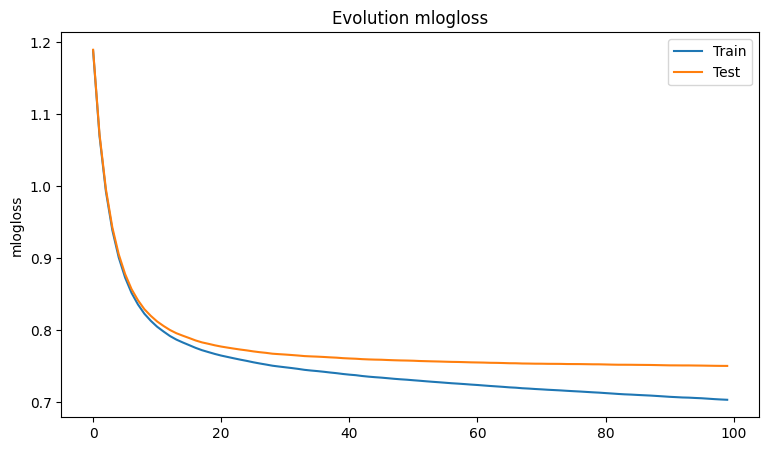

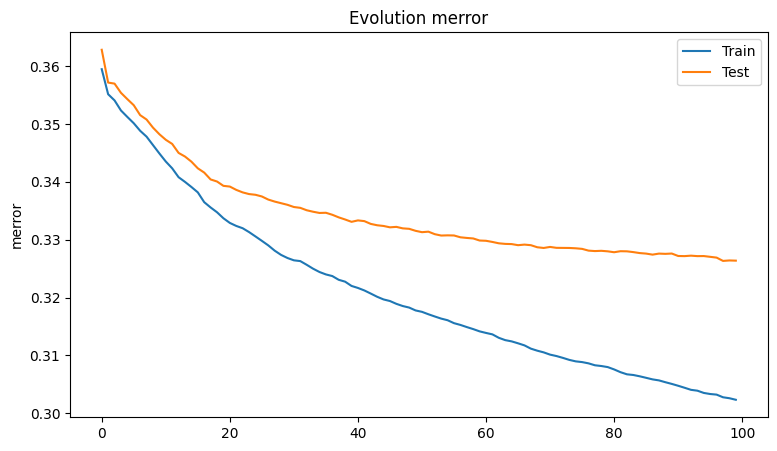


------------------ Confusion Matrix -----------------

prédiction      0      1     2    3
réalité                            
0           30135   5828   927   20
1            8991  23704  3325   58
2            1746   5884  6215  155
3             291    612  1351  186

-------------------- Key Metrics --------------------

Accuracy: 0.67
Balanced Accuracy: 0.50

Micro Precision: 0.67
Micro Recall: 0.67
Micro F1-score: 0.67

Macro Precision: 0.59
Macro Recall: 0.50
Macro F1-score: 0.51

Weighted Precision: 0.66
Weighted Recall: 0.67
Weighted F1-score: 0.66

--------------- Classification Report ---------------

                    pre       rec       spe        f1       geo       iba       sup

     Indemne       0.73      0.82      0.79      0.77      0.80      0.65     36910
Blessé Léger       0.66      0.66      0.77      0.66      0.71      0.50     36078
Blessé Grave       0.53      0.44      0.93      0.48      0.64      0.39     14000
         Tué       0.44      0.08      1.0

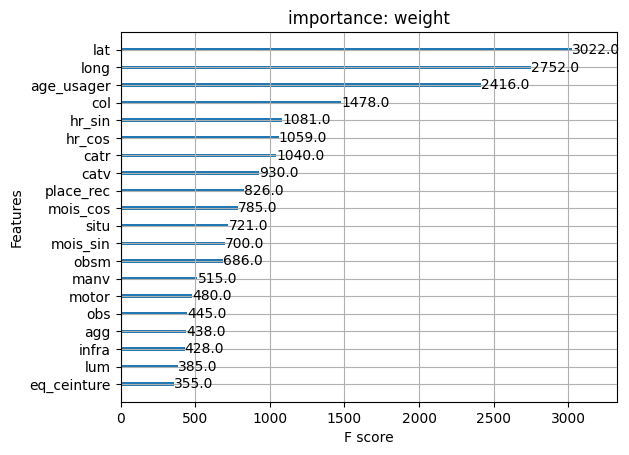

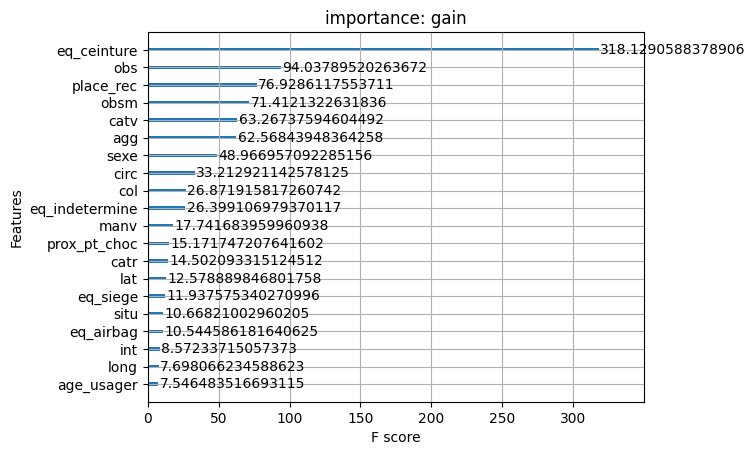

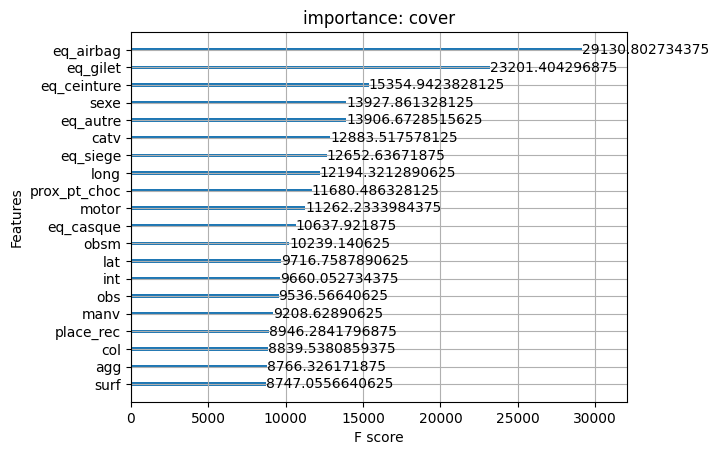

In [11]:
eval_perf(xgb_clf)

### Méthode 2 : Application d'une class_weight lors du .fit()

#### Définition et entrainement du modèle

In [15]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

imb_xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['mlogloss','merror'], 
                            seed=42)
imb_xgb_clf.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-mlogloss:1.24939	validation_0-merror:0.44599	validation_1-mlogloss:1.25096	validation_1-merror:0.44889
[1]	validation_0-mlogloss:1.16673	validation_0-merror:0.44210	validation_1-mlogloss:1.16916	validation_1-merror:0.44543
[2]	validation_0-mlogloss:1.11183	validation_0-merror:0.43716	validation_1-mlogloss:1.11518	validation_1-merror:0.44060
[3]	validation_0-mlogloss:1.07317	validation_0-merror:0.43432	validation_1-mlogloss:1.07730	validation_1-merror:0.43849
[4]	validation_0-mlogloss:1.04420	validation_0-merror:0.42830	validation_1-mlogloss:1.04907	validation_1-merror:0.43320
[5]	validation_0-mlogloss:1.01909	validation_0-merror:0.42583	validation_1-mlogloss:1.02456	validation_1-merror:0.43191
[6]	validation_0-mlogloss:1.00109	validation_0-merror:0.42375	validation_1-mlogloss:1.00714	validation_1-merror:0.42981
[7]	validation_0-mlogloss:0.98805	validation_0-merror:0.42180	validation_1-mlogloss:0.99458	validation_1-merror:0.42757
[8]	validation_0-mlogloss:0.97663	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

#### Evaluation de la performance

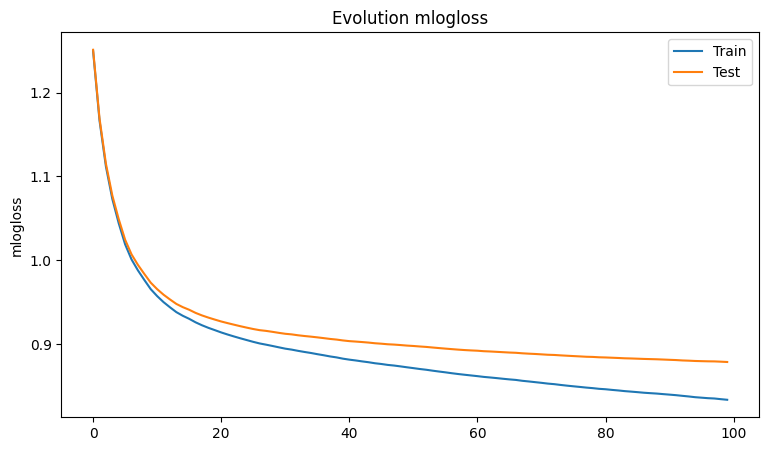

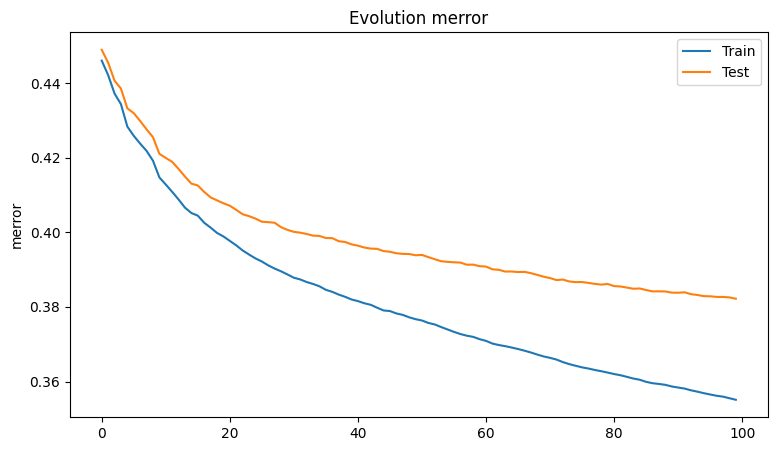


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28789   4633  2185  1303
1            8322  18292  6792  2672
2            1175   2510  6780  3535
3             151    173   728  1388

-------------------- Key Metrics --------------------

Accuracy: 0.62
Balanced Accuracy: 0.59

Micro Precision: 0.62
Micro Recall: 0.62
Micro F1-score: 0.62

Macro Precision: 0.51
Macro Recall: 0.59
Macro F1-score: 0.51

Weighted Precision: 0.67
Weighted Recall: 0.62
Weighted F1-score: 0.63

--------------- Classification Report ---------------

                    pre       rec       spe        f1       geo       iba       sup

     Indemne       0.75      0.78      0.82      0.76      0.80      0.63     36910
Blessé Léger       0.71      0.51      0.86      0.59      0.66      0.42     36078
Blessé Grave       0.41      0.48      0.87      0.44      0.65      0.41     14000
         Tué       0.16      0.57   

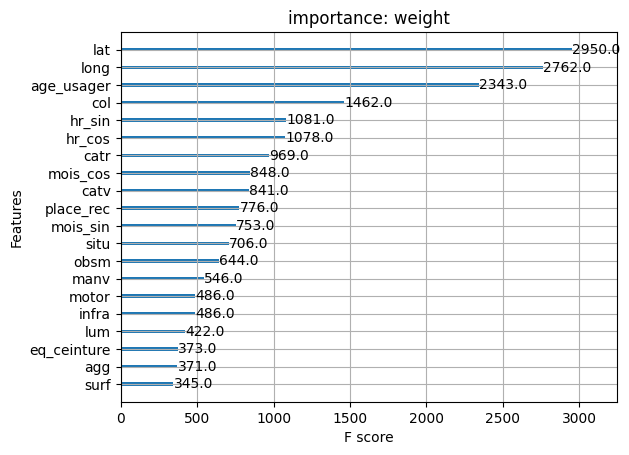

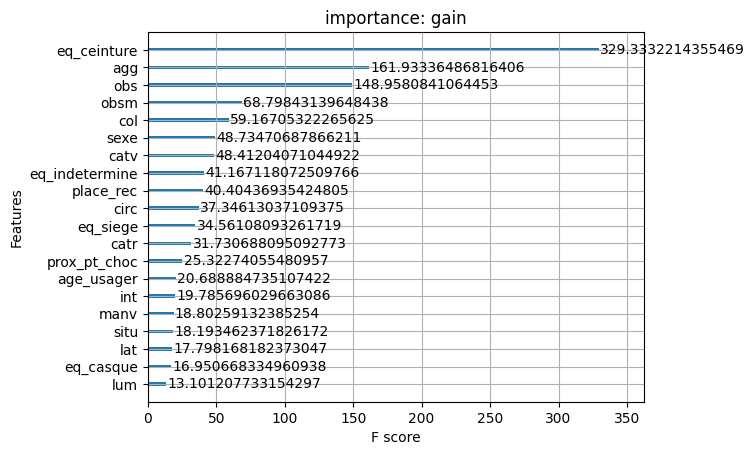

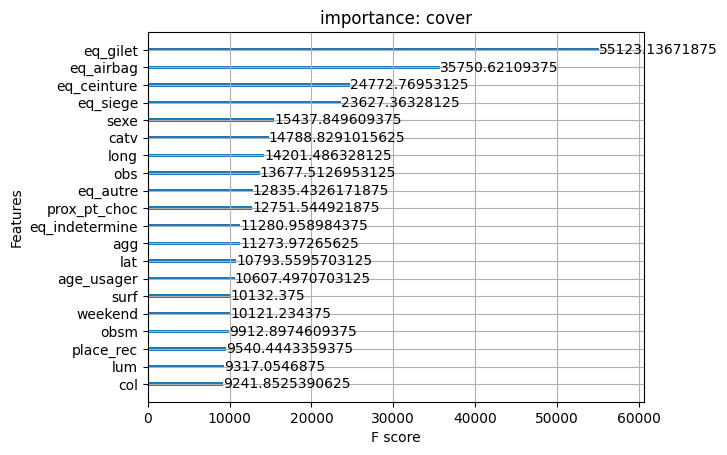

In [16]:
eval_perf(imb_xgb_clf)

### Méthode 3 : Application d'un RandomOverSampling sur le dataset

#### Application d'un rééquilibrage avec RandomOverSampling

In [17]:
ros = RandomOverSampler(sampling_strategy='all')
X_ro, y_ro = ros.fit_resample(X_train, y_train)
print(y_ro.value_counts())

grav
0    147638
2    147638
1    147638
3    147638
Name: count, dtype: int64


#### Définition modèle et entrainenemt

In [19]:
# XGBoost model v1
ros_xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
ros_xgb_clf.fit(X_ro, 
            y_ro,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

#### Evaluation de la performance

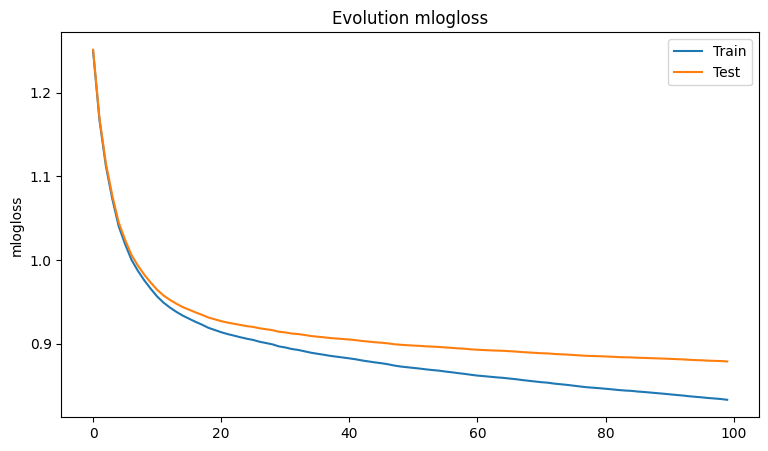

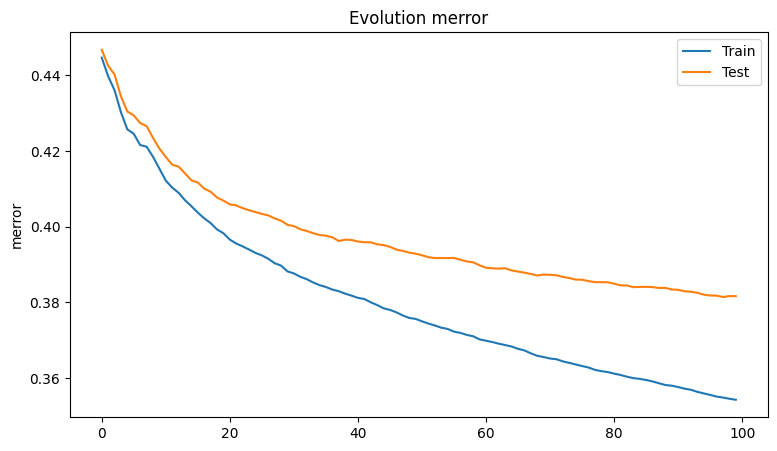


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28809   4697  2105  1299
1            8258  18443  6714  2663
2            1164   2597  6662  3577
3             156    181   718  1385

-------------------- Key Metrics --------------------

Accuracy: 0.62
Balanced Accuracy: 0.58

Micro Precision: 0.62
Micro Recall: 0.62
Micro F1-score: 0.62

Macro Precision: 0.51
Macro Recall: 0.58
Macro F1-score: 0.51

Weighted Precision: 0.67
Weighted Recall: 0.62
Weighted F1-score: 0.63

--------------- Classification Report ---------------

                    pre       rec       spe        f1       geo       iba       sup

     Indemne       0.75      0.78      0.82      0.77      0.80      0.64     36910
Blessé Léger       0.71      0.51      0.86      0.59      0.66      0.42     36078
Blessé Grave       0.41      0.48      0.87      0.44      0.64      0.40     14000
         Tué       0.16      0.57   

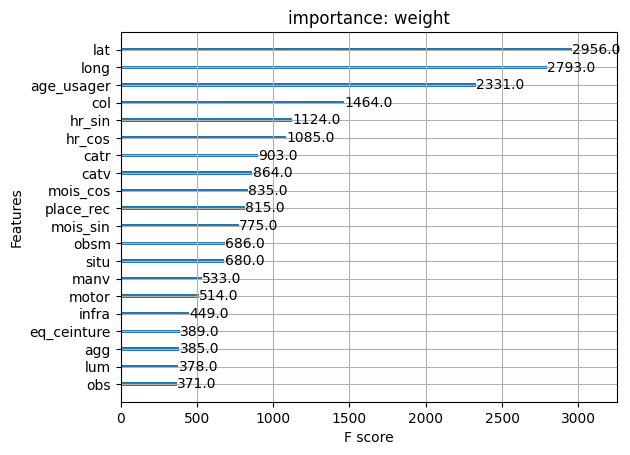

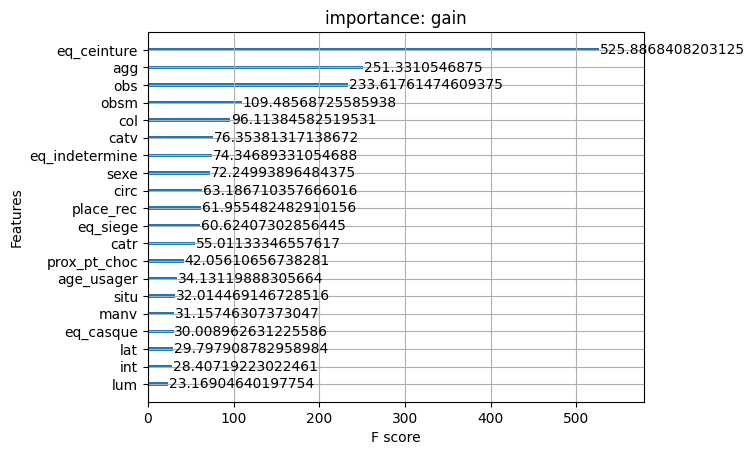

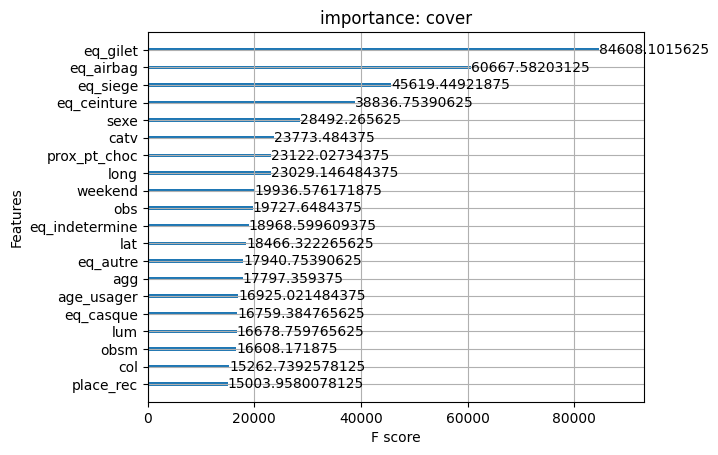

In [20]:
eval_perf(ros_xgb_clf)

### Optimisation des hyperparamètres

##### max_depth 9, n_estimators 100, lr=0.3

In [26]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model1 = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=9,
                            )
model1.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.41028	validation_0-mlogloss:1.22773	validation_1-merror:0.42130	validation_1-mlogloss:1.23148
[1]	validation_0-merror:0.40371	validation_0-mlogloss:1.13297	validation_1-merror:0.41509	validation_1-mlogloss:1.14000
[2]	validation_0-merror:0.39957	validation_0-mlogloss:1.06947	validation_1-merror:0.41285	validation_1-mlogloss:1.07979
[3]	validation_0-merror:0.39763	validation_0-mlogloss:1.02394	validation_1-merror:0.41195	validation_1-mlogloss:1.03725
[4]	validation_0-merror:0.39491	validation_0-mlogloss:0.99114	validation_1-merror:0.41062	validation_1-mlogloss:1.00727
[5]	validation_0-merror:0.39090	validation_0-mlogloss:0.96454	validation_1-merror:0.40738	validation_1-mlogloss:0.98332
[6]	validation_0-merror:0.38697	validation_0-mlogloss:0.94451	validation_1-merror:0.40516	validation_1-mlogloss:0.96606
[7]	validation_0-merror:0.38440	validation_0-mlogloss:0.92887	validation_1-merror:0.40353	validation_1-mlogloss:0.95286
[8]	validation_0-merror:0.37956	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

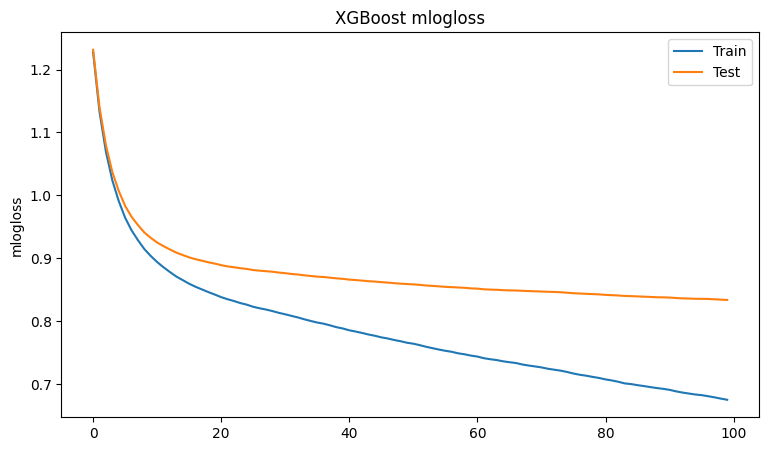

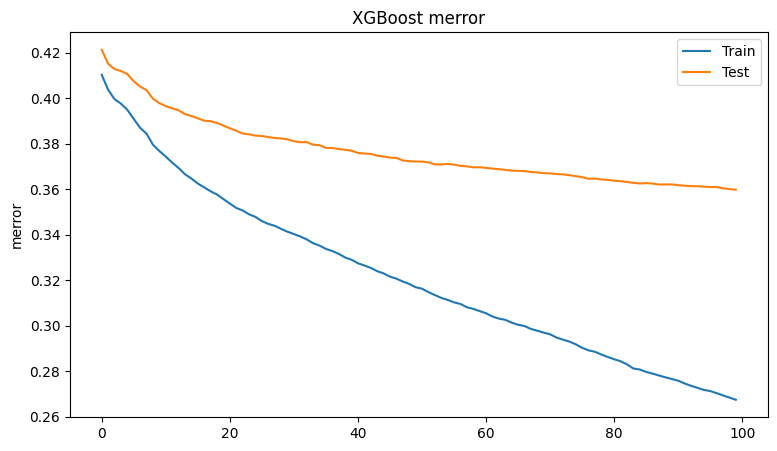


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28767   5062  2297   784
1            8145  19734  6675  1524
2            1279   2723  7645  2353
3             114    219  1002  1105

-------------------- Key Metrics --------------------

Accuracy: 0.64
Balanced Accuracy: 0.58

Micro Precision: 0.64
Micro Recall: 0.64
Micro F1-score: 0.64

Macro Precision: 0.52
Macro Recall: 0.58
Macro F1-score: 0.53

Weighted Precision: 0.67
Weighted Recall: 0.64
Weighted F1-score: 0.65

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.75      0.78      0.76     36910
Blessé Léger       0.71      0.55      0.62     36078
Blessé Grave       0.43      0.55      0.48     14000
         Tué       0.19      0.45      0.27      2440

    accuracy                           0.64     89428
   macro avg       0.52      0.58      0.53    

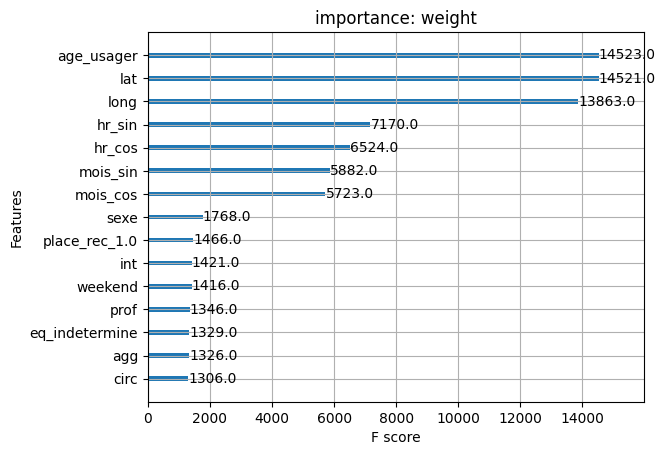

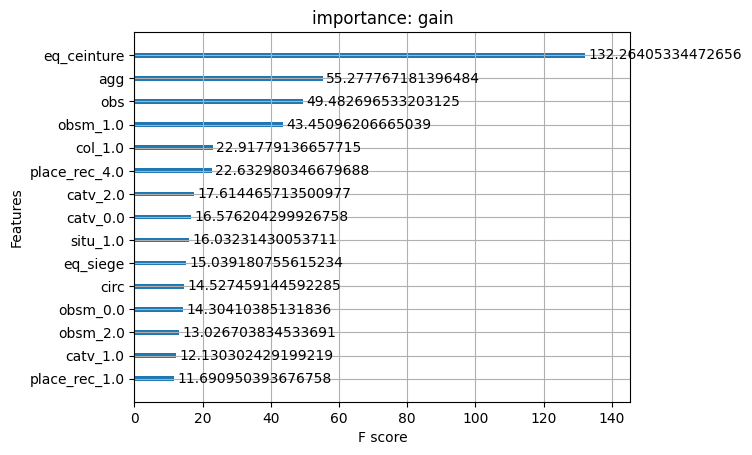

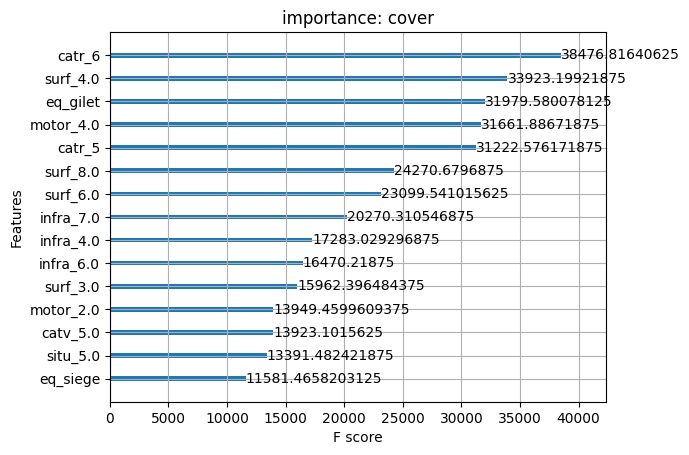

In [27]:
eval_perf(model1)

##### max_depth 9, n_estimators 100, lr=0.1

In [28]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model1b = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=9,
                            learning_rate=0.1)
model1b.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.41028	validation_0-mlogloss:1.32934	validation_1-merror:0.42130	validation_1-mlogloss:1.33058
[1]	validation_0-merror:0.40765	validation_0-mlogloss:1.28186	validation_1-merror:0.41846	validation_1-mlogloss:1.28428
[2]	validation_0-merror:0.40782	validation_0-mlogloss:1.24111	validation_1-merror:0.41876	validation_1-mlogloss:1.24470
[3]	validation_0-merror:0.40548	validation_0-mlogloss:1.20548	validation_1-merror:0.41694	validation_1-mlogloss:1.21015
[4]	validation_0-merror:0.40324	validation_0-mlogloss:1.17422	validation_1-merror:0.41472	validation_1-mlogloss:1.17998
[5]	validation_0-merror:0.40155	validation_0-mlogloss:1.14699	validation_1-merror:0.41318	validation_1-mlogloss:1.15374
[6]	validation_0-merror:0.40056	validation_0-mlogloss:1.12246	validation_1-merror:0.41287	validation_1-mlogloss:1.13026
[7]	validation_0-merror:0.39970	validation_0-mlogloss:1.10091	validation_1-merror:0.41178	validation_1-mlogloss:1.10975
[8]	validation_0-merror:0.39883	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

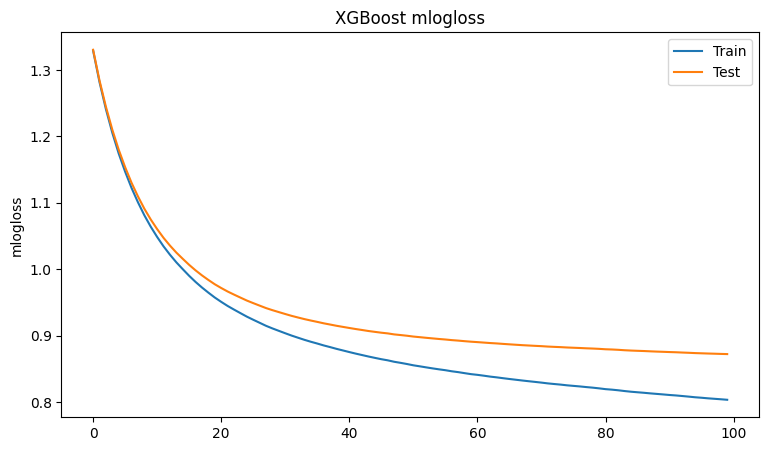

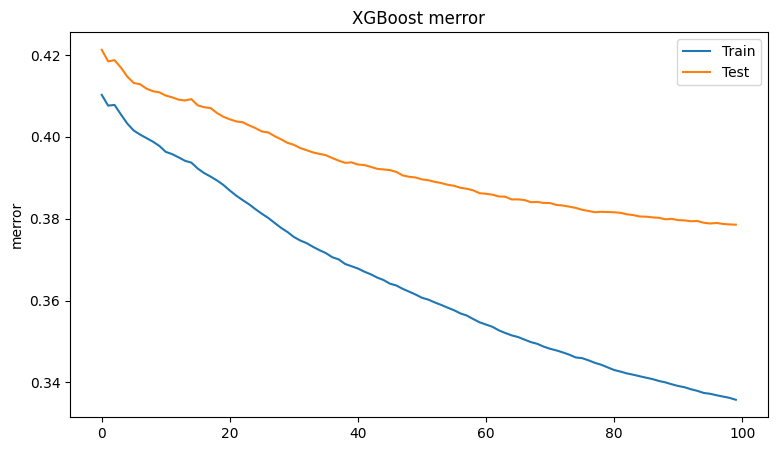


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28782   4716  2264  1148
1            8436  18391  6944  2307
2            1275   2417  7044  3264
3             119    175   787  1359

-------------------- Key Metrics --------------------

Accuracy: 0.62
Balanced Accuracy: 0.59

Micro Precision: 0.62
Micro Recall: 0.62
Micro F1-score: 0.62

Macro Precision: 0.51
Macro Recall: 0.59
Macro F1-score: 0.52

Weighted Precision: 0.67
Weighted Recall: 0.62
Weighted F1-score: 0.63

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.75      0.78      0.76     36910
Blessé Léger       0.72      0.51      0.60     36078
Blessé Grave       0.41      0.50      0.45     14000
         Tué       0.17      0.56      0.26      2440

    accuracy                           0.62     89428
   macro avg       0.51      0.59      0.52    

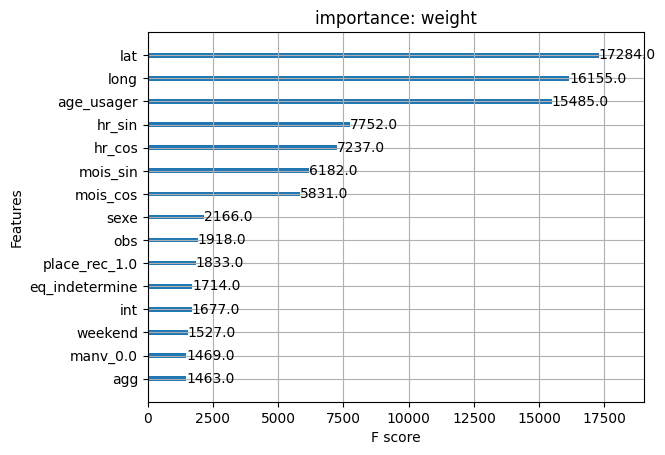

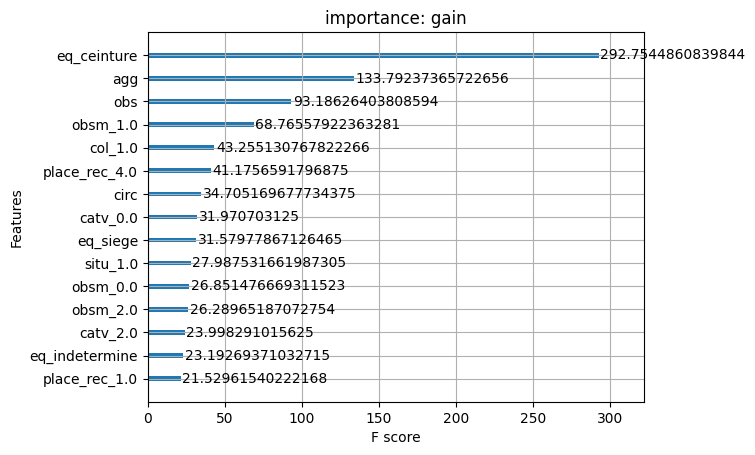

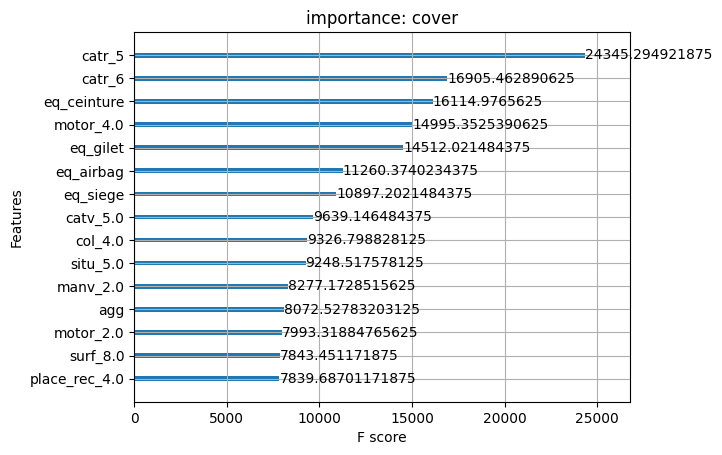

In [29]:
eval_perf(model1b)

##### max_depth 3, n_estimators 100, lr 0.1

In [30]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model2b = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=3,
                            learning_rate=0.1)
model2b.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.47984	validation_0-mlogloss:1.35286	validation_1-merror:0.47903	validation_1-mlogloss:1.35283
[1]	validation_0-merror:0.48469	validation_0-mlogloss:1.32514	validation_1-merror:0.48553	validation_1-mlogloss:1.32517
[2]	validation_0-merror:0.48287	validation_0-mlogloss:1.30139	validation_1-merror:0.48459	validation_1-mlogloss:1.30145
[3]	validation_0-merror:0.48560	validation_0-mlogloss:1.27957	validation_1-merror:0.48731	validation_1-mlogloss:1.27972
[4]	validation_0-merror:0.48209	validation_0-mlogloss:1.25979	validation_1-merror:0.48377	validation_1-mlogloss:1.25994
[5]	validation_0-merror:0.47958	validation_0-mlogloss:1.24320	validation_1-merror:0.48185	validation_1-mlogloss:1.24336
[6]	validation_0-merror:0.48311	validation_0-mlogloss:1.22775	validation_1-merror:0.48505	validation_1-mlogloss:1.22802
[7]	validation_0-merror:0.48002	validation_0-mlogloss:1.21379	validation_1-merror:0.48218	validation_1-mlogloss:1.21404
[8]	validation_0-merror:0.48206	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

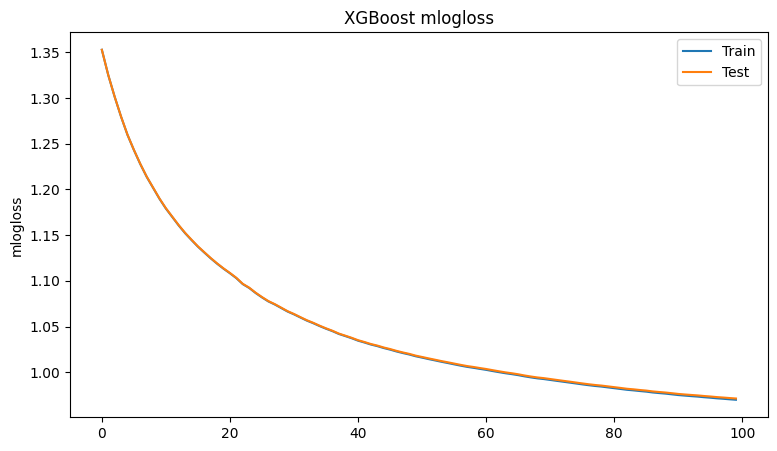

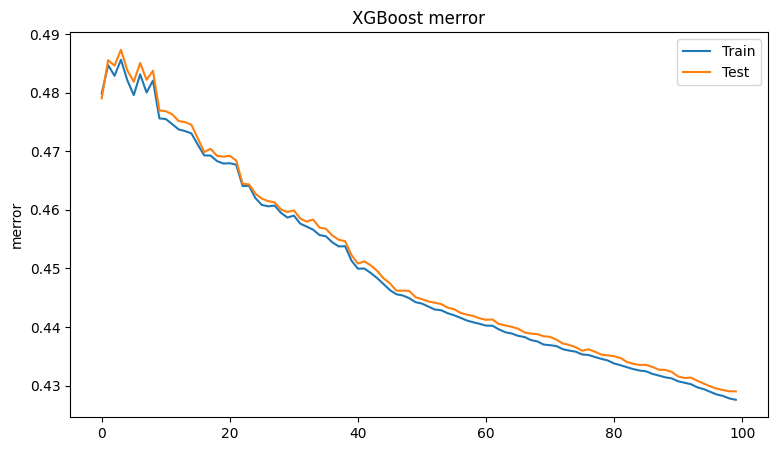


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28835   4198  1670  2207
1           10077  15038  7039  3924
2            1516   2186  5639  4659
3             156    184   550  1550

-------------------- Key Metrics --------------------

Accuracy: 0.57
Balanced Accuracy: 0.56

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.48
Macro Recall: 0.56
Macro F1-score: 0.47

Weighted Precision: 0.64
Weighted Recall: 0.57
Weighted F1-score: 0.58

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.71      0.78      0.74     36910
Blessé Léger       0.70      0.42      0.52     36078
Blessé Grave       0.38      0.40      0.39     14000
         Tué       0.13      0.64      0.21      2440

    accuracy                           0.57     89428
   macro avg       0.48      0.56      0.47    

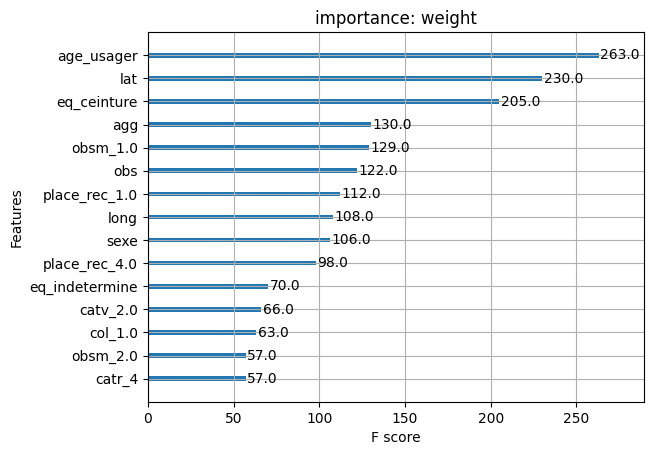

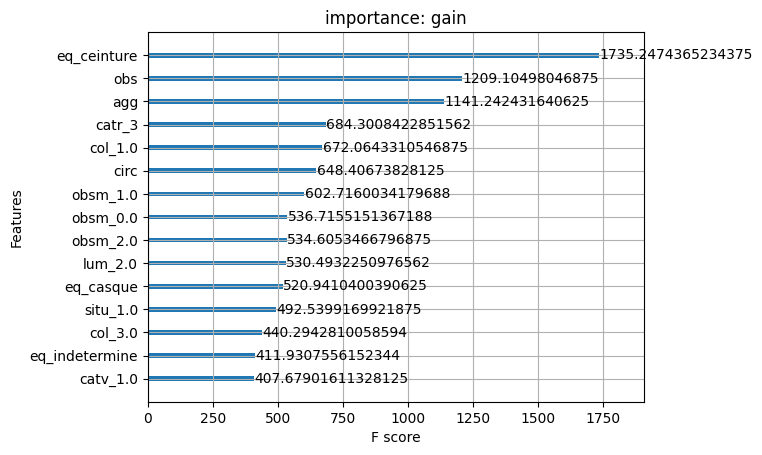

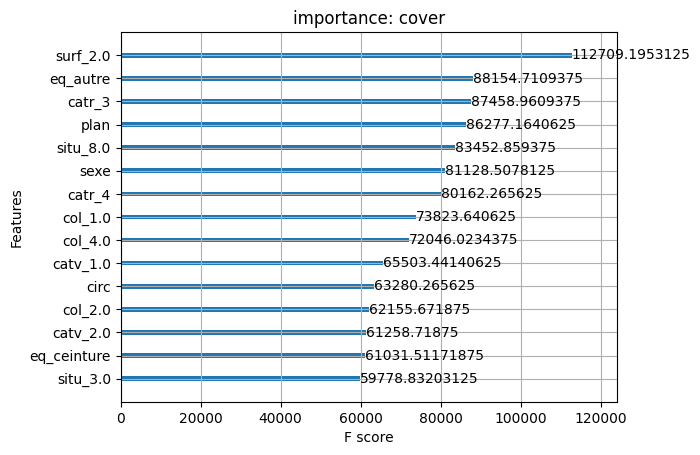

In [31]:
eval_perf(model2b)

##### max_depth 3, n_estimators 150, lr 0.1

In [32]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model2c = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=3,
                            learning_rate=0.1,
                            n_estimators=150)
model2c.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.47984	validation_0-mlogloss:1.35286	validation_1-merror:0.47903	validation_1-mlogloss:1.35283
[1]	validation_0-merror:0.48469	validation_0-mlogloss:1.32514	validation_1-merror:0.48553	validation_1-mlogloss:1.32517
[2]	validation_0-merror:0.48287	validation_0-mlogloss:1.30139	validation_1-merror:0.48459	validation_1-mlogloss:1.30145
[3]	validation_0-merror:0.48560	validation_0-mlogloss:1.27957	validation_1-merror:0.48731	validation_1-mlogloss:1.27972
[4]	validation_0-merror:0.48209	validation_0-mlogloss:1.25979	validation_1-merror:0.48377	validation_1-mlogloss:1.25994
[5]	validation_0-merror:0.47958	validation_0-mlogloss:1.24320	validation_1-merror:0.48185	validation_1-mlogloss:1.24336
[6]	validation_0-merror:0.48311	validation_0-mlogloss:1.22775	validation_1-merror:0.48505	validation_1-mlogloss:1.22802
[7]	validation_0-merror:0.48002	validation_0-mlogloss:1.21379	validation_1-merror:0.48218	validation_1-mlogloss:1.21404
[8]	validation_0-merror:0.48206	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

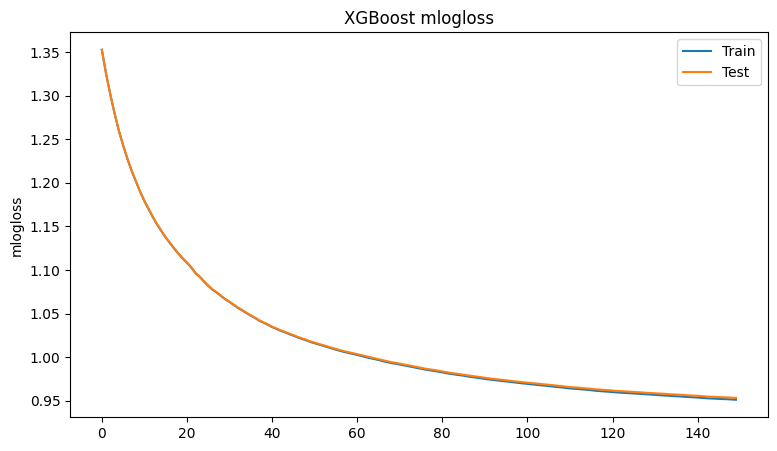

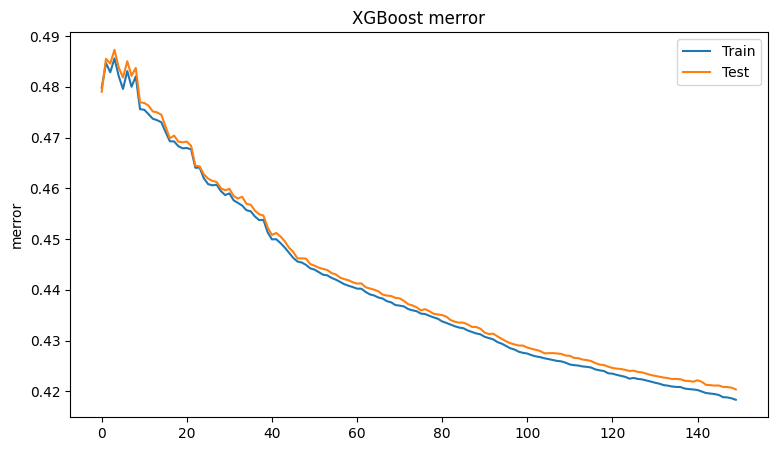


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28931   4186  1719  2074
1            9780  15581  6995  3722
2            1444   2224  5771  4561
3             145    180   563  1552

-------------------- Key Metrics --------------------

Accuracy: 0.58
Balanced Accuracy: 0.57

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.48
Macro Recall: 0.57
Macro F1-score: 0.47

Weighted Precision: 0.64
Weighted Recall: 0.58
Weighted F1-score: 0.59

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.72      0.78      0.75     36910
Blessé Léger       0.70      0.43      0.53     36078
Blessé Grave       0.38      0.41      0.40     14000
         Tué       0.13      0.64      0.22      2440

    accuracy                           0.58     89428
   macro avg       0.48      0.57      0.47    

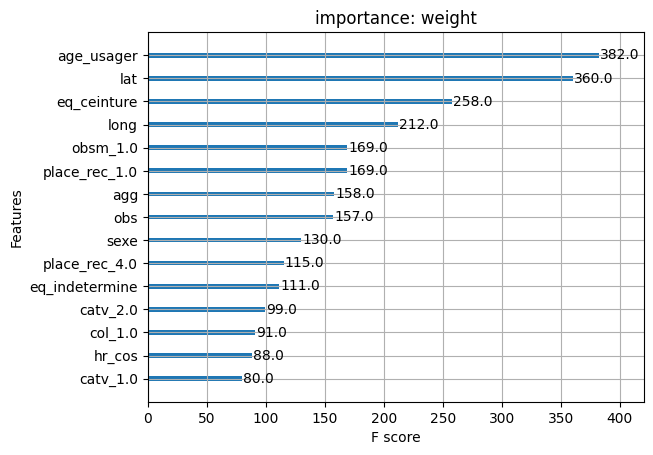

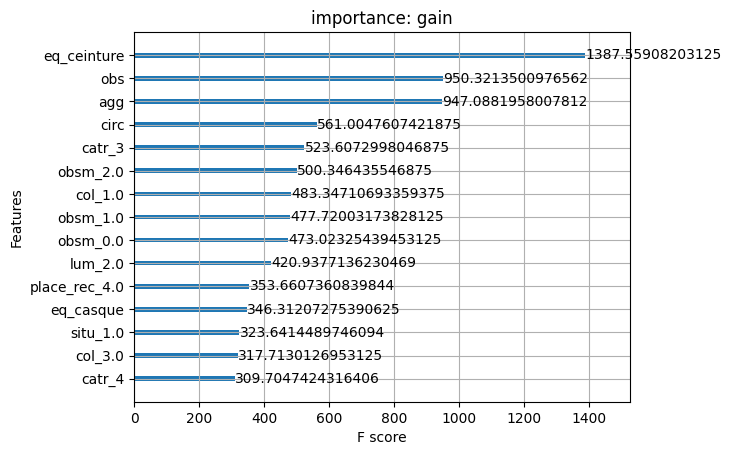

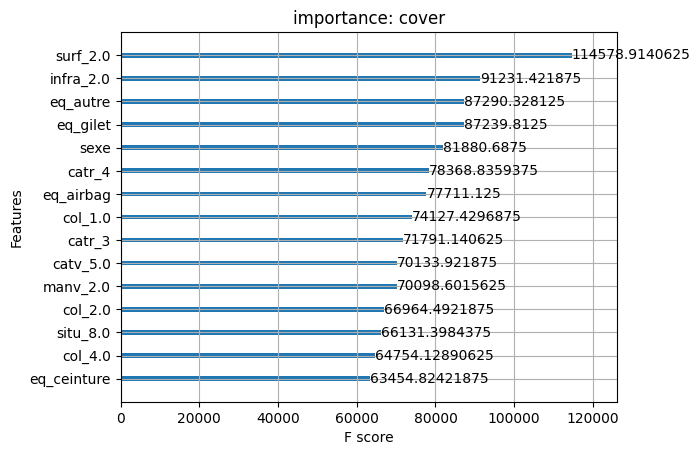

In [33]:
eval_perf(model2c)

##### max_depth 3, n_estimators 200, lr 0.1

In [34]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model2d = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=3,
                            learning_rate=0.1,
                            n_estimators=200)
model2d.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.47984	validation_0-mlogloss:1.35286	validation_1-merror:0.47903	validation_1-mlogloss:1.35283
[1]	validation_0-merror:0.48469	validation_0-mlogloss:1.32514	validation_1-merror:0.48553	validation_1-mlogloss:1.32517
[2]	validation_0-merror:0.48287	validation_0-mlogloss:1.30139	validation_1-merror:0.48459	validation_1-mlogloss:1.30145
[3]	validation_0-merror:0.48560	validation_0-mlogloss:1.27957	validation_1-merror:0.48731	validation_1-mlogloss:1.27972
[4]	validation_0-merror:0.48209	validation_0-mlogloss:1.25979	validation_1-merror:0.48377	validation_1-mlogloss:1.25994
[5]	validation_0-merror:0.47958	validation_0-mlogloss:1.24320	validation_1-merror:0.48185	validation_1-mlogloss:1.24336
[6]	validation_0-merror:0.48311	validation_0-mlogloss:1.22775	validation_1-merror:0.48505	validation_1-mlogloss:1.22802
[7]	validation_0-merror:0.48002	validation_0-mlogloss:1.21379	validation_1-merror:0.48218	validation_1-mlogloss:1.21404
[8]	validation_0-merror:0.48206	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

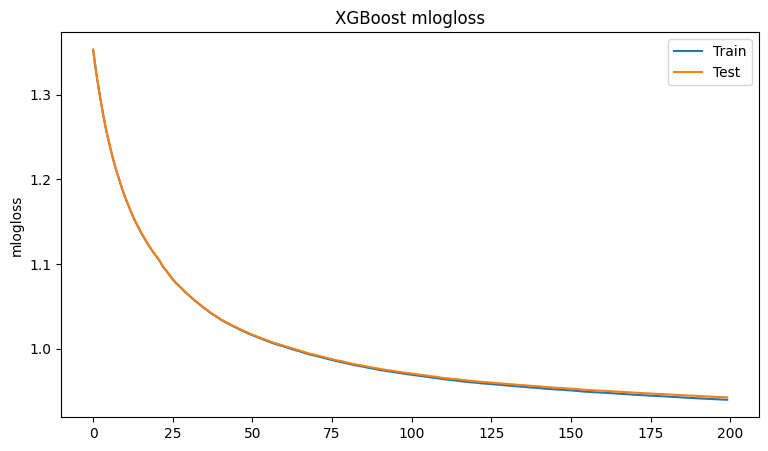

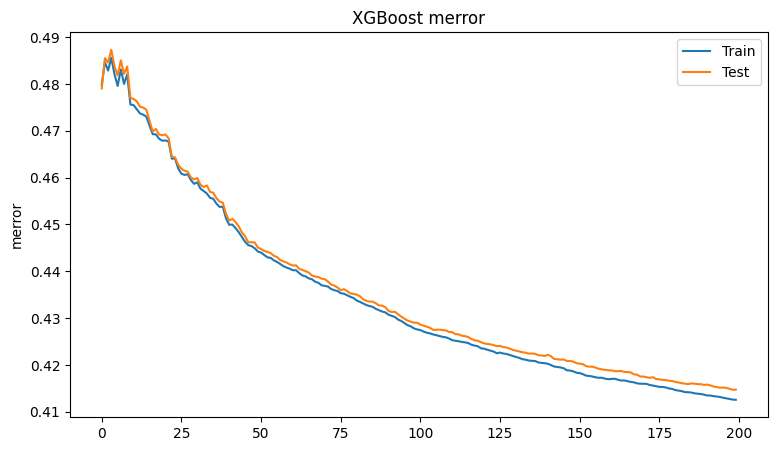


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28925   4237  1777  1971
1            9577  16000  6940  3561
2            1398   2256  5860  4486
3             141    179   565  1555

-------------------- Key Metrics --------------------

Accuracy: 0.59
Balanced Accuracy: 0.57

Micro Precision: 0.59
Micro Recall: 0.59
Micro F1-score: 0.59

Macro Precision: 0.49
Macro Recall: 0.57
Macro F1-score: 0.48

Weighted Precision: 0.65
Weighted Recall: 0.59
Weighted F1-score: 0.60

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.72      0.78      0.75     36910
Blessé Léger       0.71      0.44      0.54     36078
Blessé Grave       0.39      0.42      0.40     14000
         Tué       0.13      0.64      0.22      2440

    accuracy                           0.59     89428
   macro avg       0.49      0.57      0.48    

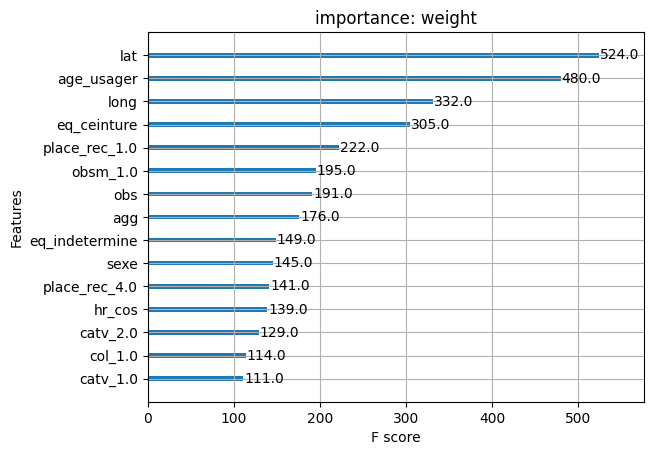

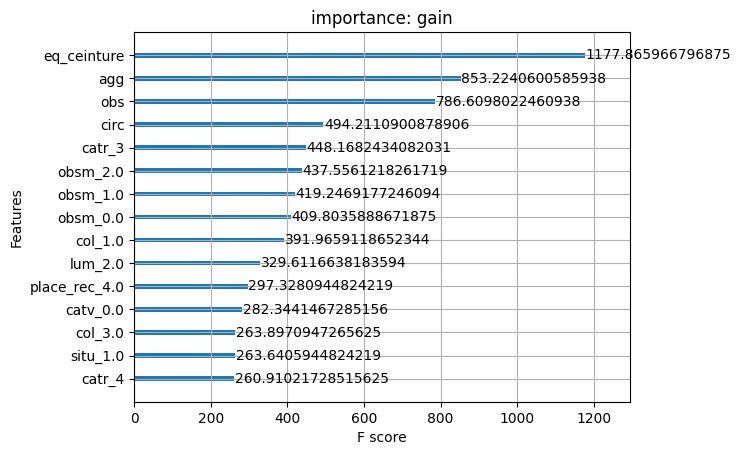

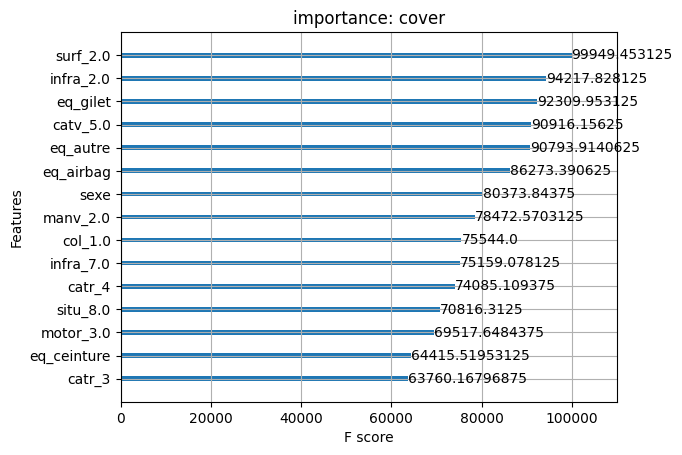

In [35]:
eval_perf(model2d)

##### max_depth 3, n_estimators 300, lr 0.1

In [36]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model2e = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=3,
                            learning_rate=0.1,
                            n_estimators=300)
model2e.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.47984	validation_0-mlogloss:1.35286	validation_1-merror:0.47903	validation_1-mlogloss:1.35283
[1]	validation_0-merror:0.48469	validation_0-mlogloss:1.32514	validation_1-merror:0.48553	validation_1-mlogloss:1.32517
[2]	validation_0-merror:0.48287	validation_0-mlogloss:1.30139	validation_1-merror:0.48459	validation_1-mlogloss:1.30145
[3]	validation_0-merror:0.48560	validation_0-mlogloss:1.27957	validation_1-merror:0.48731	validation_1-mlogloss:1.27972
[4]	validation_0-merror:0.48209	validation_0-mlogloss:1.25979	validation_1-merror:0.48377	validation_1-mlogloss:1.25994
[5]	validation_0-merror:0.47958	validation_0-mlogloss:1.24320	validation_1-merror:0.48185	validation_1-mlogloss:1.24336
[6]	validation_0-merror:0.48311	validation_0-mlogloss:1.22775	validation_1-merror:0.48505	validation_1-mlogloss:1.22802
[7]	validation_0-merror:0.48002	validation_0-mlogloss:1.21379	validation_1-merror:0.48218	validation_1-mlogloss:1.21404
[8]	validation_0-merror:0.48206	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

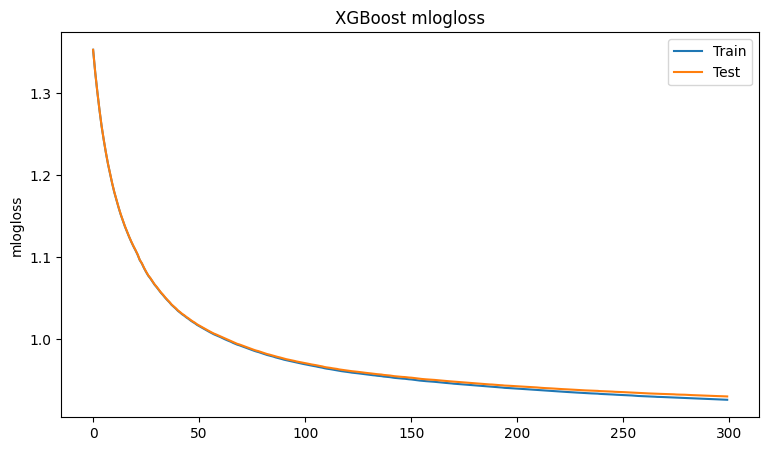

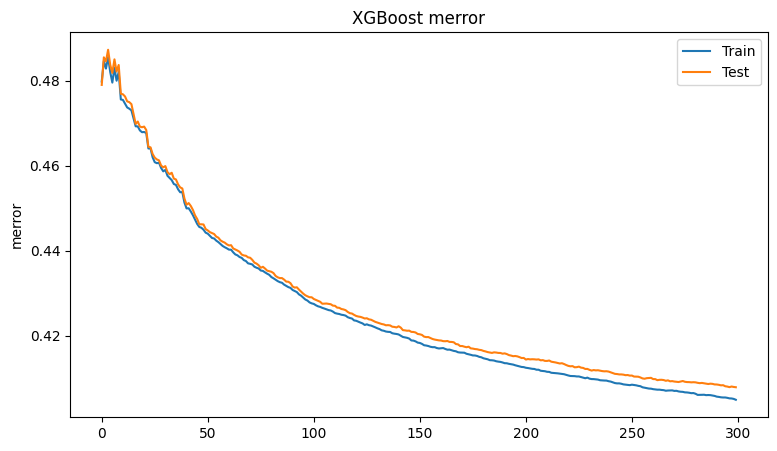


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28959   4292  1841  1818
1            9359  16437  6889  3393
2            1338   2287  6008  4367
3             129    177   581  1553

-------------------- Key Metrics --------------------

Accuracy: 0.59
Balanced Accuracy: 0.58

Micro Precision: 0.59
Micro Recall: 0.59
Micro F1-score: 0.59

Macro Precision: 0.49
Macro Recall: 0.58
Macro F1-score: 0.49

Weighted Precision: 0.65
Weighted Recall: 0.59
Weighted F1-score: 0.61

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.73      0.78      0.76     36910
Blessé Léger       0.71      0.46      0.55     36078
Blessé Grave       0.39      0.43      0.41     14000
         Tué       0.14      0.64      0.23      2440

    accuracy                           0.59     89428
   macro avg       0.49      0.58      0.49    

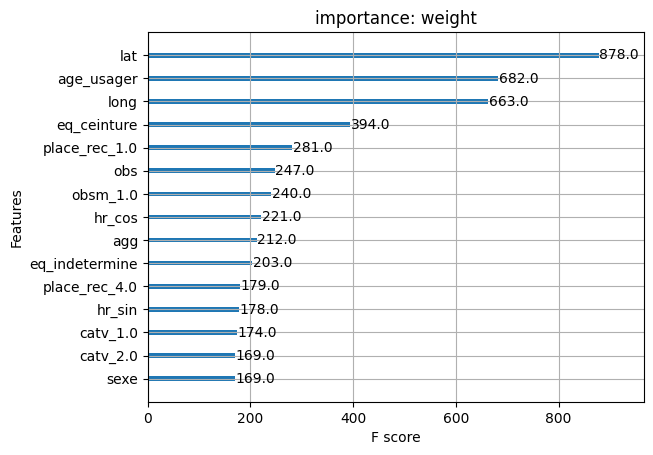

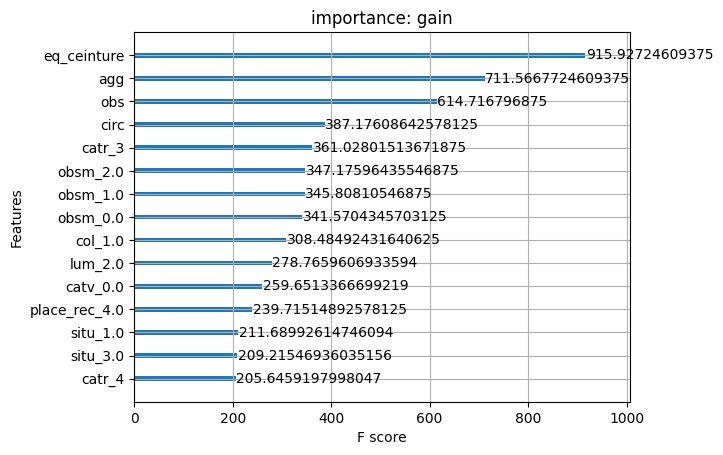

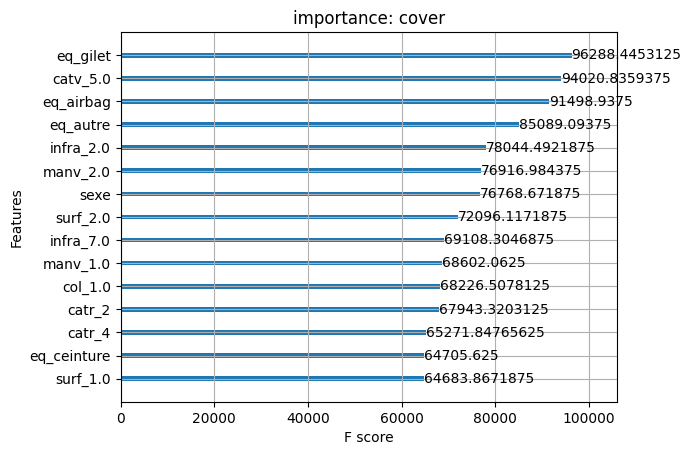

In [37]:
eval_perf(model2e)

##### max_depth 3, n_estimators 200, lr 0.05

In [21]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model2f = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=3,
                            learning_rate=0.05,
                            n_estimators=200)
model2f.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.50264	validation_0-mlogloss:1.36906	validation_1-merror:0.50327	validation_1-mlogloss:1.36921
[1]	validation_0-merror:0.50240	validation_0-mlogloss:1.35309	validation_1-merror:0.50303	validation_1-mlogloss:1.35337
[2]	validation_0-merror:0.50395	validation_0-mlogloss:1.33814	validation_1-merror:0.50473	validation_1-mlogloss:1.33855
[3]	validation_0-merror:0.50420	validation_0-mlogloss:1.32429	validation_1-merror:0.50510	validation_1-mlogloss:1.32483
[4]	validation_0-merror:0.50376	validation_0-mlogloss:1.31142	validation_1-merror:0.50489	validation_1-mlogloss:1.31202
[5]	validation_0-merror:0.50681	validation_0-mlogloss:1.29899	validation_1-merror:0.50779	validation_1-mlogloss:1.29970
[6]	validation_0-merror:0.50701	validation_0-mlogloss:1.28748	validation_1-merror:0.50793	validation_1-mlogloss:1.28829
[7]	validation_0-merror:0.50092	validation_0-mlogloss:1.27629	validation_1-merror:0.50215	validation_1-mlogloss:1.27724
[8]	validation_0-merror:0.50094	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

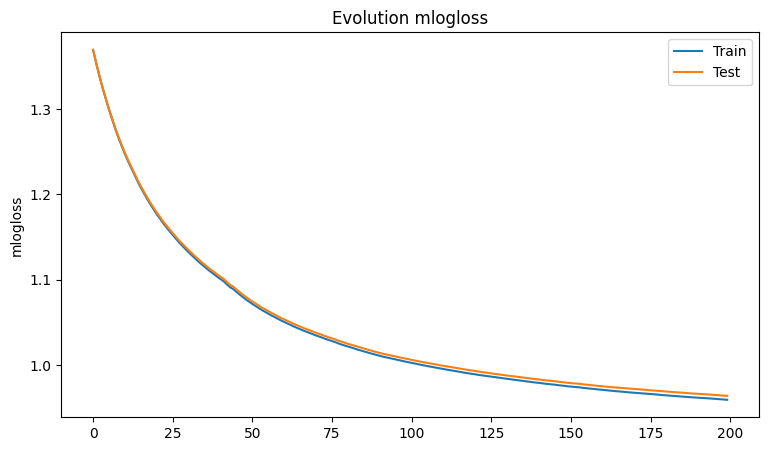

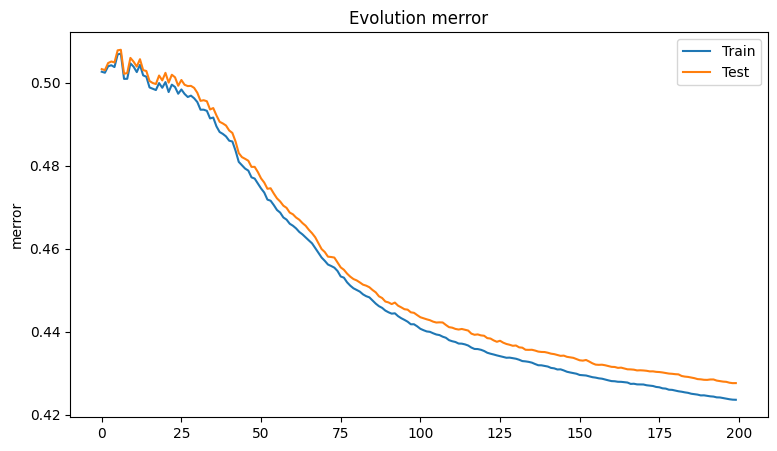


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           29315   3893  1577  2125
1           10176  14620  7183  4099
2            1493   2195  5710  4602
3             195    184   519  1542

-------------------- Key Metrics --------------------

Accuracy: 0.57
Balanced Accuracy: 0.56

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.48
Macro Recall: 0.56
Macro F1-score: 0.47

Weighted Precision: 0.64
Weighted Recall: 0.57
Weighted F1-score: 0.58

--------------- Classification Report ---------------

                    pre       rec       spe        f1       geo       iba       sup

     Indemne       0.71      0.79      0.77      0.75      0.78      0.62     36910
Blessé Léger       0.70      0.41      0.88      0.51      0.60      0.34     36078
Blessé Grave       0.38      0.41      0.88      0.39      0.60      0.34     14000
         Tué       0.12      0.63   

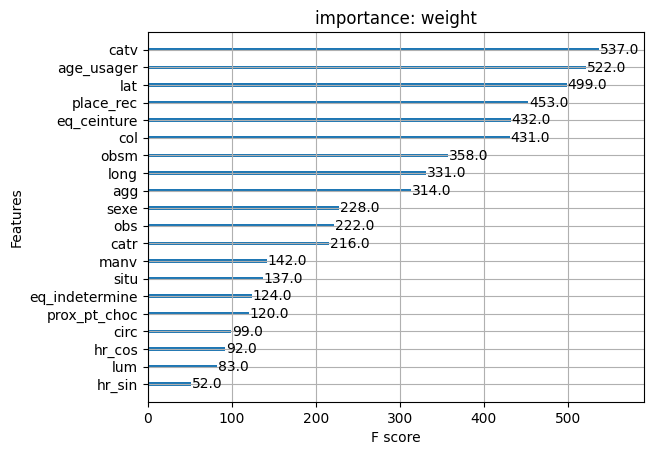

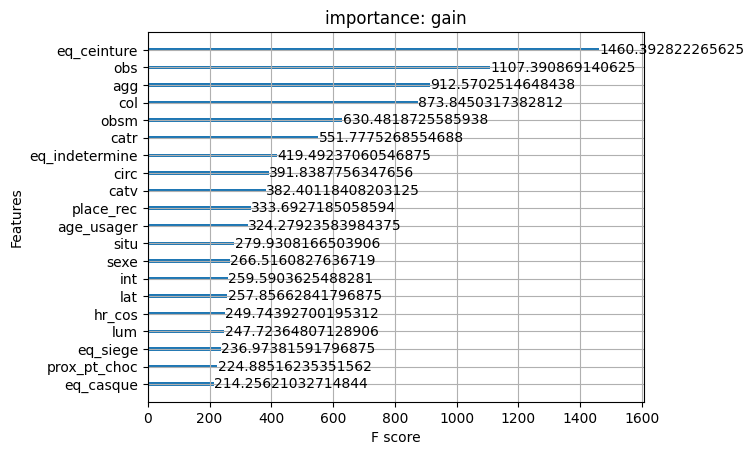

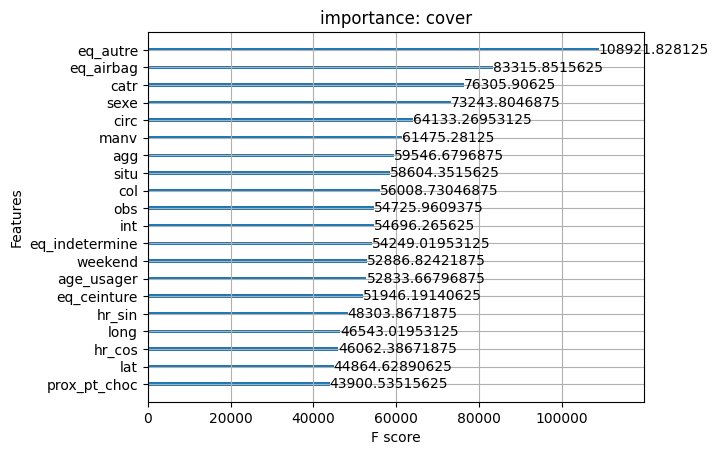

In [22]:
eval_perf(model2f)

##### max_depth 3, n_estimators 200, lr 0.01

In [40]:
# traitement du déséquilibre
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

model2g = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            max_depth=3,
                            learning_rate=0.01,
                            n_estimators=200)
model2g.fit(X_train, 
            y_train,
            verbose=1,# set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.47984	validation_0-mlogloss:1.38285	validation_1-merror:0.47903	validation_1-mlogloss:1.38285
[1]	validation_0-merror:0.47984	validation_0-mlogloss:1.37946	validation_1-merror:0.47903	validation_1-mlogloss:1.37946
[2]	validation_0-merror:0.47984	validation_0-mlogloss:1.37613	validation_1-merror:0.47903	validation_1-mlogloss:1.37612
[3]	validation_0-merror:0.47701	validation_0-mlogloss:1.37292	validation_1-merror:0.47639	validation_1-mlogloss:1.37291
[4]	validation_0-merror:0.47916	validation_0-mlogloss:1.36977	validation_1-merror:0.47887	validation_1-mlogloss:1.36976
[5]	validation_0-merror:0.48009	validation_0-mlogloss:1.36666	validation_1-merror:0.47955	validation_1-mlogloss:1.36665
[6]	validation_0-merror:0.48015	validation_0-mlogloss:1.36360	validation_1-merror:0.47958	validation_1-mlogloss:1.36359
[7]	validation_0-merror:0.48252	validation_0-mlogloss:1.36058	validation_1-merror:0.48239	validation_1-mlogloss:1.36057
[8]	validation_0-merror:0.47936	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

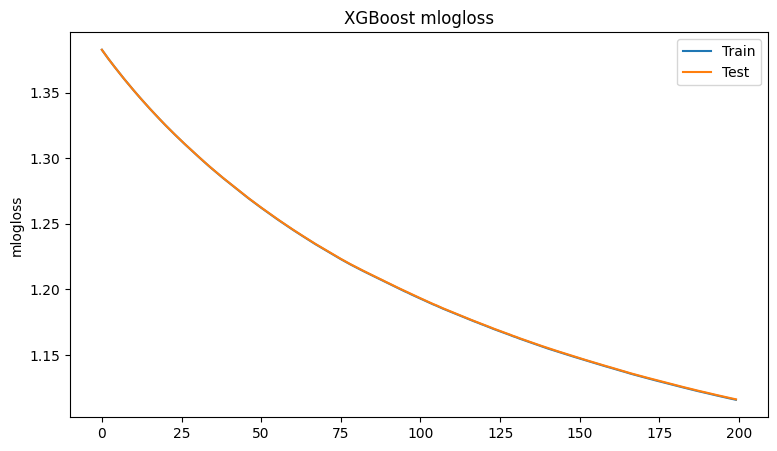

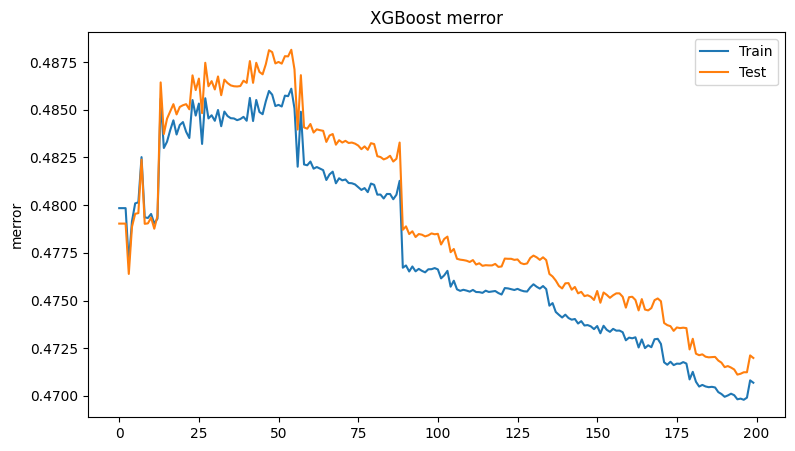


------------------ Confusion Matrix -----------------

prédiction      0      1     2     3
réalité                             
0           28538   4116  1634  2622
1           12254  12506  6460  4858
2            2301   2064  4692  4943
3             276    183   498  1483

-------------------- Key Metrics --------------------

Accuracy: 0.53
Balanced Accuracy: 0.52

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.45
Macro Recall: 0.52
Macro F1-score: 0.42

Weighted Precision: 0.60
Weighted Recall: 0.53
Weighted F1-score: 0.54

--------------- Classification Report ---------------

              precision    recall  f1-score   support

     Indemne       0.66      0.77      0.71     36910
Blessé Léger       0.66      0.35      0.46     36078
Blessé Grave       0.35      0.34      0.34     14000
         Tué       0.11      0.61      0.18      2440

    accuracy                           0.53     89428
   macro avg       0.45      0.52      0.42    

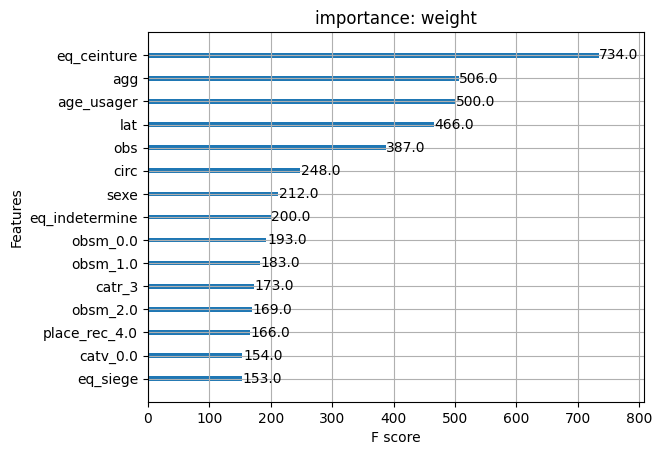

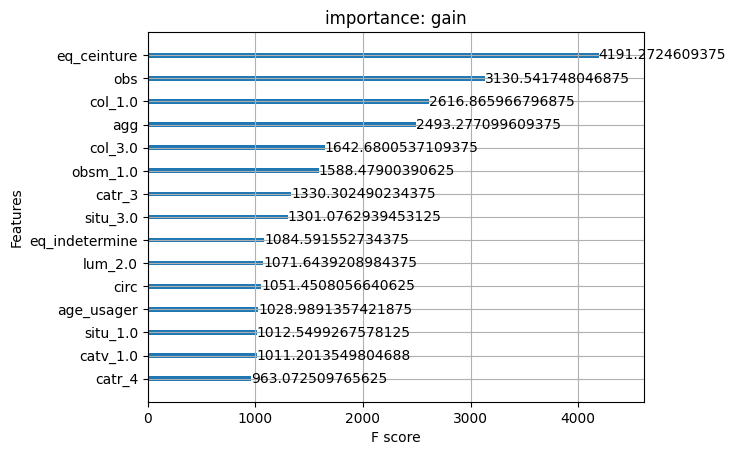

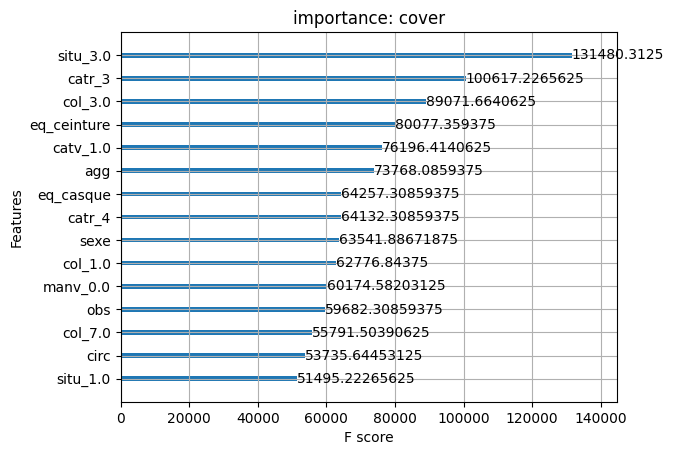

In [41]:
eval_perf(model2g)


## Interprétabilité

In [35]:
import shap

explainer = shap.TreeExplainer(model2f)

shap_values = explainer.shap_values(X_test)

print('Expected Value', explainer.expected_value)


Expected Value [0.44956934, 0.52571976, 0.52366364, 0.49266768]


In [36]:
shap_values[0].shape

(37, 4)

In [37]:
print(type(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

<class 'numpy.ndarray'>
(37, 4)
(37, 4)


In [38]:
shap.initjs()

In [39]:
explainer.expected_value[3]

0.49266768

In [45]:
pd.DataFrame(shap_values[3]).head(50)

0         1         2         3
0  -0.007206 -0.001128  0.002785  0.171183
1  -0.095389 -0.179131  0.121976  0.412794
2   0.008331  0.000038  0.002641 -0.123244
3   0.000000  0.000000  0.000000 -0.000156
4   0.105911  0.052182 -0.126695 -0.341507
5  -0.033847 -0.055203  0.111280  0.047922
6  -0.004169 -0.079205  0.055962  0.006807
7  -0.088969 -0.206606  0.075719  0.116049
8   0.000000 -0.054568  0.050542  0.014216
9   0.000000  0.000000  0.000000  0.000000
10  0.000000  0.000000  0.000000  0.000000
11  0.001951 -0.001306  0.000000  0.000000
12  0.000000  0.000000  0.000000 -0.005765
13  0.004470  0.035311 -0.000705 -0.020766
14  0.002429 -0.158806 -0.068170  0.003978
15 -0.895106  0.054177  0.334863  0.006109
16  0.102236  0.034541 -0.007526 -0.056187
17 -0.177612  0.016803 -0.005339 -0.016486
18  0.000000  0.063936  0.027678 -0.019210
19  0.000711 -0.001431 -0.000002  0.000066
20  0.000000  0.002993  0.000000  0.000000
21  0.041181 -0.032177 -0.016854 -0.011852
22  0.017249  0.075052 -0.014800 -0.122452
23 -0.844209 -0.166439  0.105848  0.426031
24  0.000000  0.013561  0.072967  0.000000
25 -0.010189  0.000000 -0.000007  0.000209
26  0.000000  0.000000  0.000000  0.000000
27  0.000000 -0.000374  0.000000  0.000000
28  0.000000  0.000000  0.000000  0.000000
29 -0.124276 -0.017859  0.011139  0.019169
30  0.000000  0.001755 -0.000176  0.000000
31  0.000000  0.000000  0.000000  0.000000
32 -0.115497 -0.000372  0.041715  0.032521
33 -0.028509 -0.017273  0.000000  0.038900
34 -0.029093 -0.034089  0.003482  0.103465
35  0.000000  0.000000  0.000043  0.000000
36  0.000000  0.000000 -0.003189 -0.000090

In [40]:
shap_values[0, :]

array([[ 4.15325724e-03,  8.63534631e-04, -8.71572236e-04,
        -7.71345347e-02],
       [ 8.76849070e-02,  7.84762427e-02, -1.12000383e-01,
        -4.38941807e-01],
       [ 8.33114982e-03,  3.82953731e-05,  7.43871555e-04,
        -8.06529447e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -9.34765412e-05],
       [ 9.82724726e-02,  2.31113117e-02, -1.37740076e-01,
        -3.34783614e-01],
       [ 1.17455564e-01,  2.15956703e-01, -4.93339986e-01,
        -2.73819029e-01],
       [ 1.18050165e-01,  1.29226416e-01, -1.79514363e-01,
        -9.54804942e-02],
       [ 1.12162106e-01,  1.47880584e-01, -1.22198753e-01,
        -1.57455266e-01],
       [ 0.00000000e+00,  5.47839813e-02, -1.63919121e-01,
        -5.24530411e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 8.17786320e-04, -1.22880540e-03,  0.00000000e+00,
      

In [41]:
shap.force_plot(explainer.expected_value[3], shap_values[300, :],)

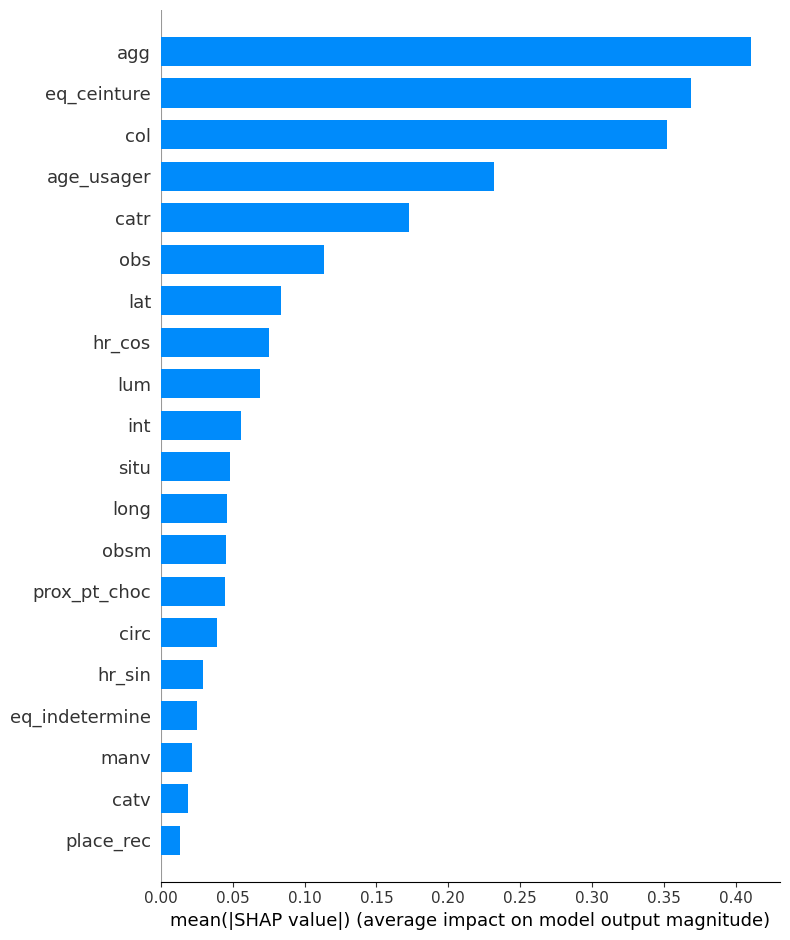

In [42]:
shap.summary_plot(shap_values[:, :, 3], X_test, plot_type="bar")

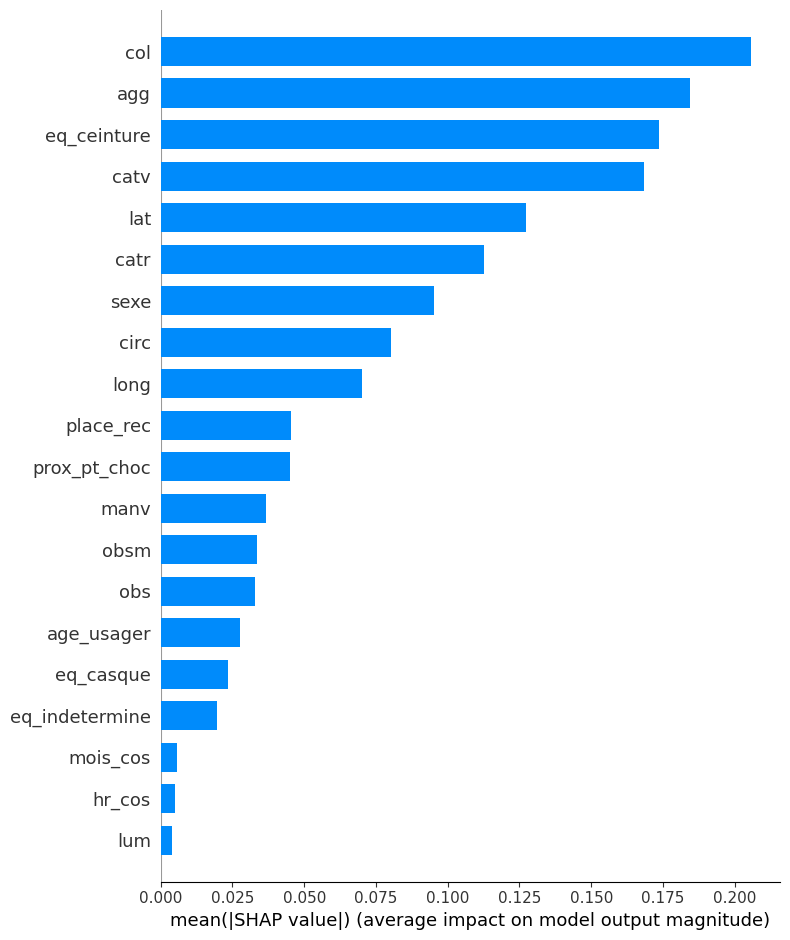

In [46]:
shap.summary_plot(shap_values[:, :, 2], X_test, plot_type="bar")

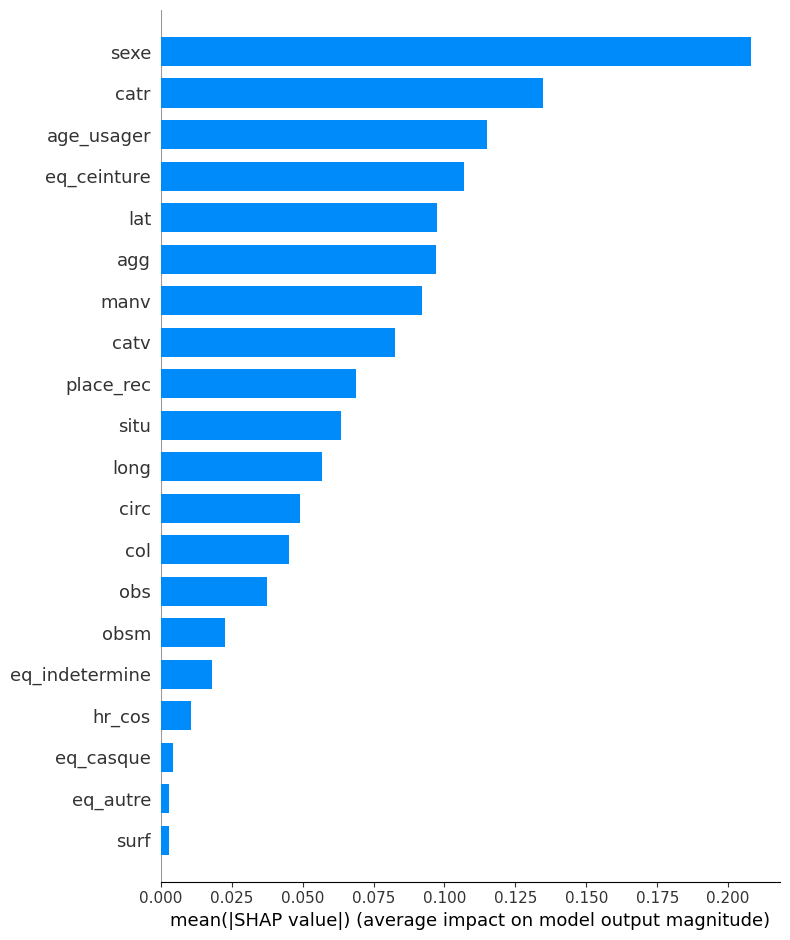

In [47]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")

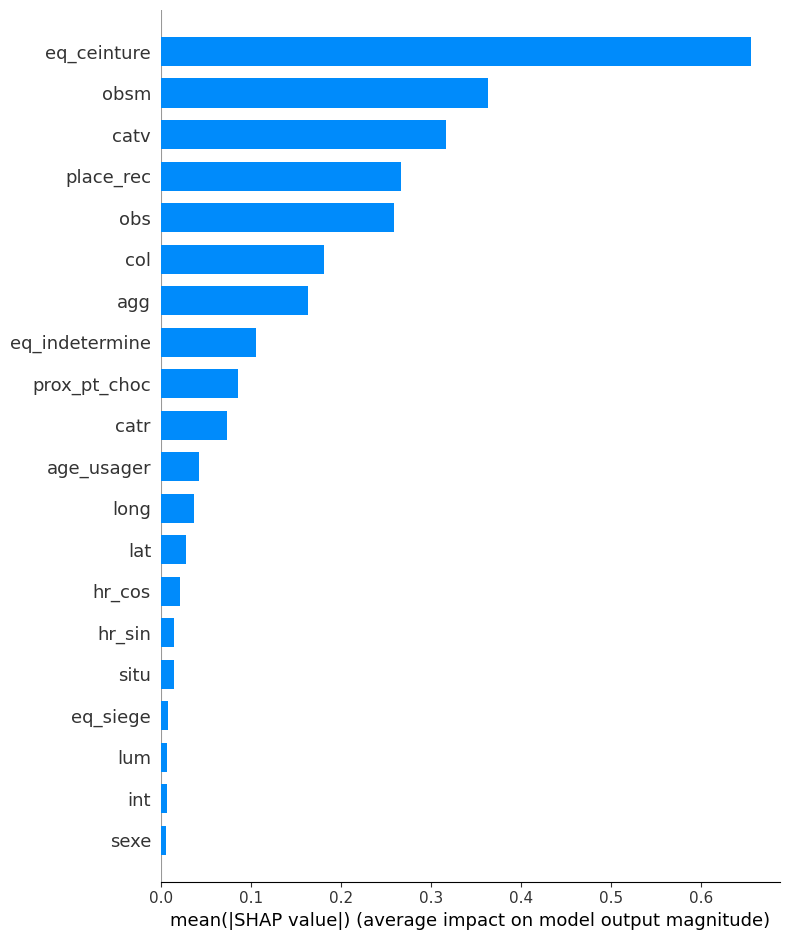

In [48]:
shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar")

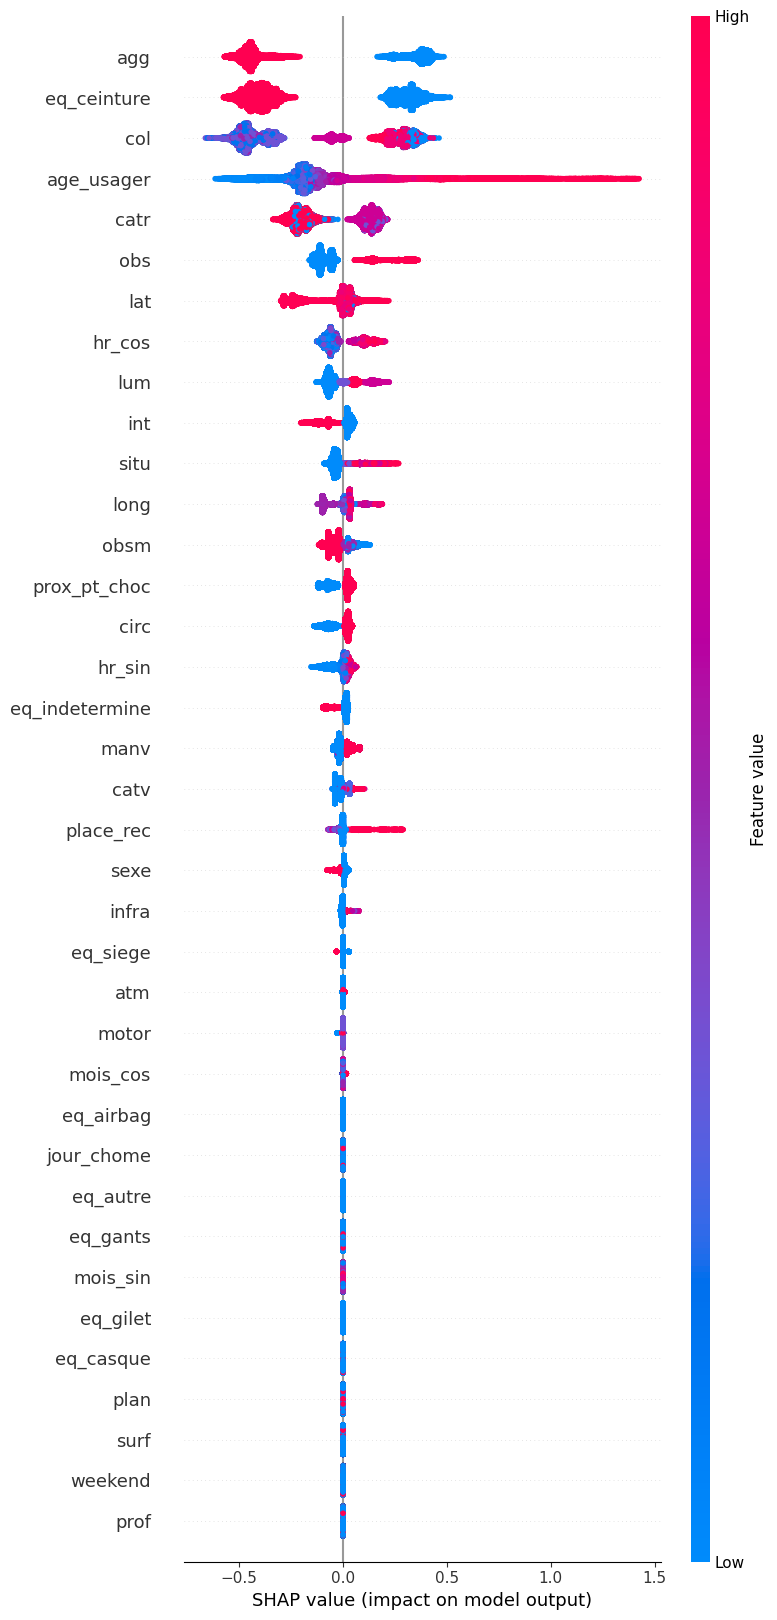

In [43]:
shap.summary_plot(shap_values[:, :, 3], X_test,max_display = len(X_test))

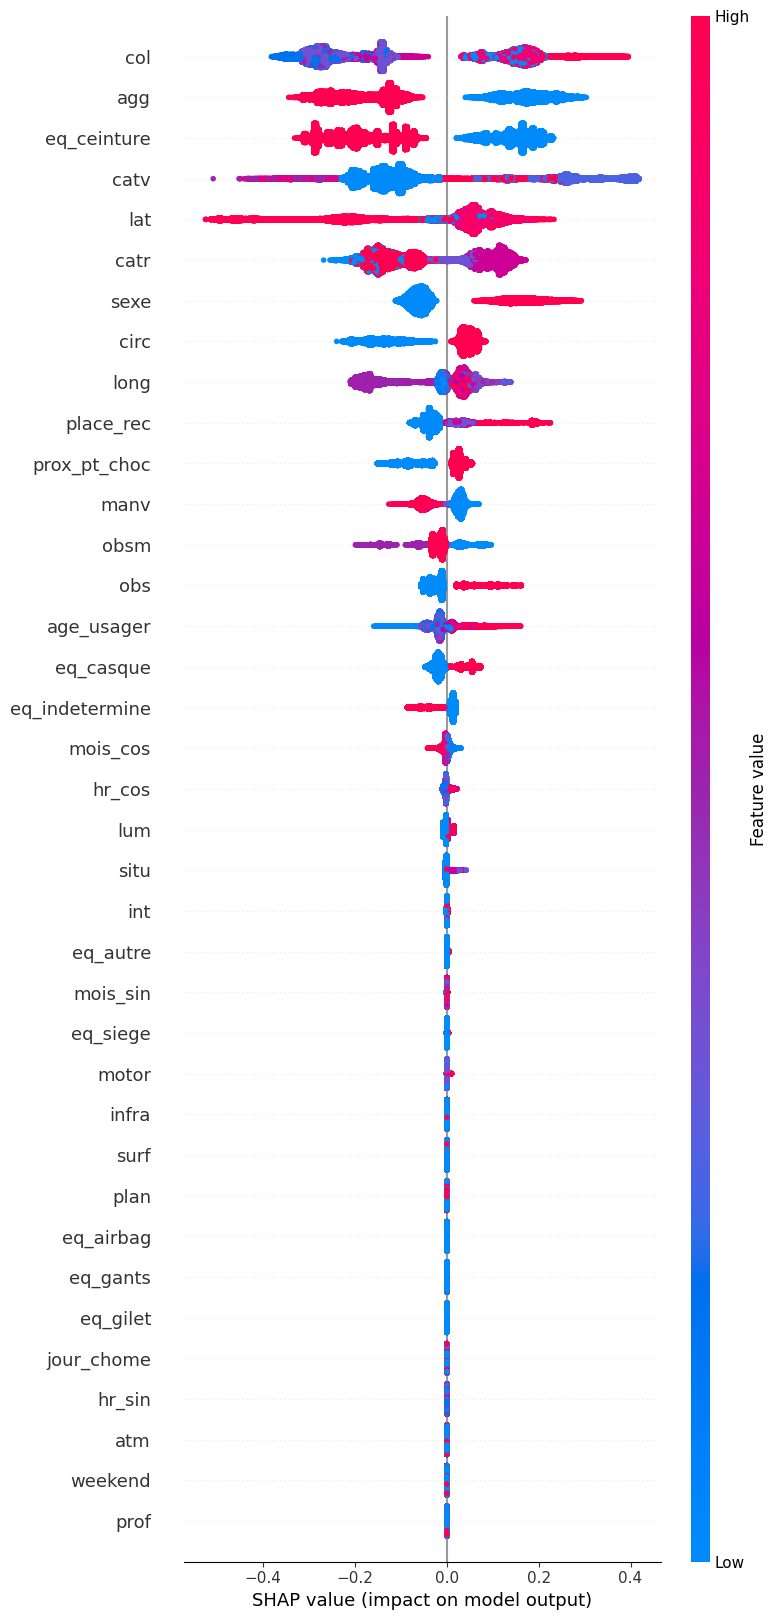

In [49]:
shap.summary_plot(shap_values[:, :, 2], X_test,max_display = len(X_test))

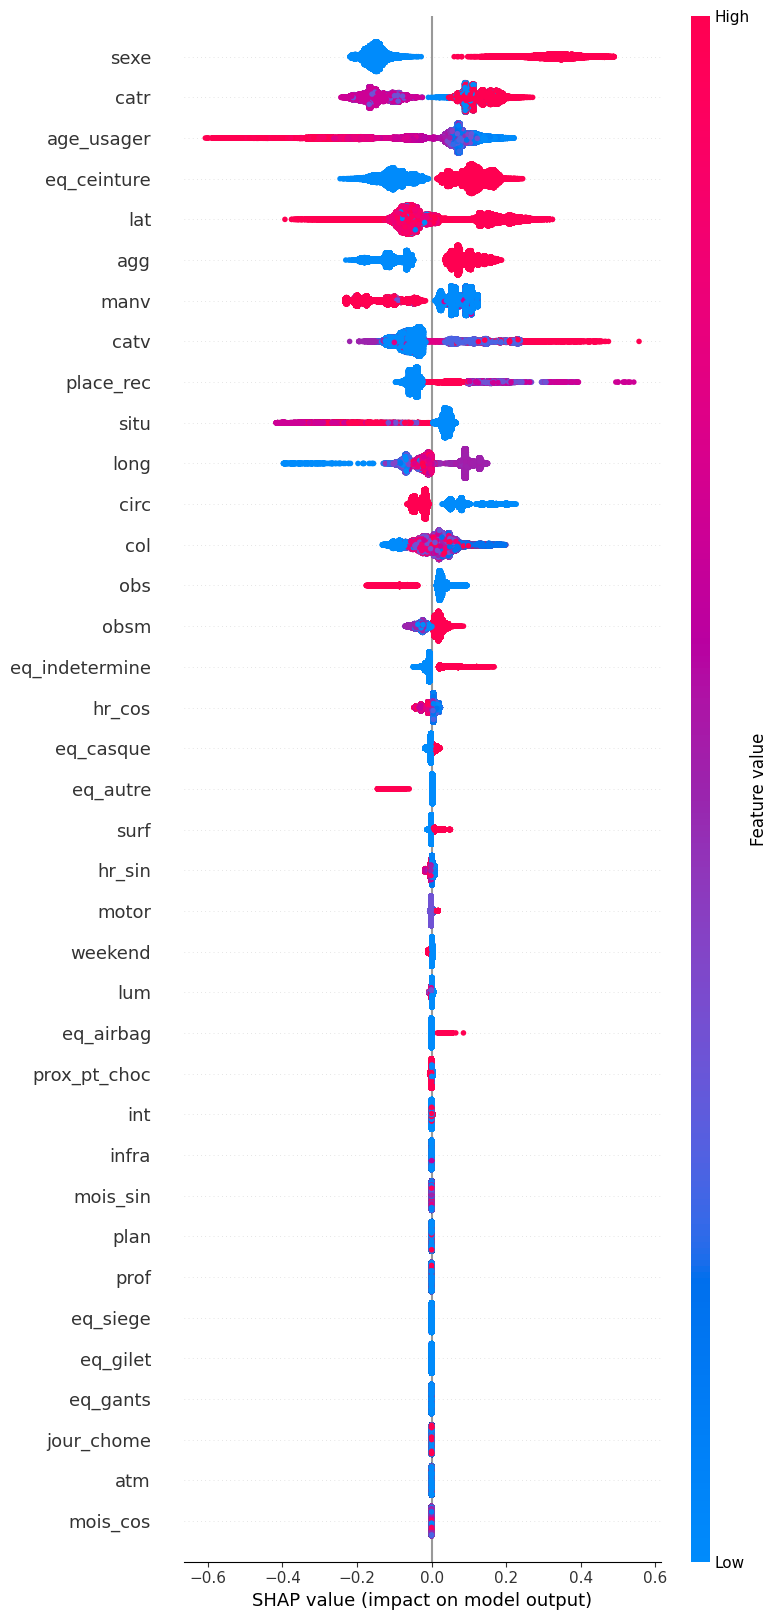

In [50]:
shap.summary_plot(shap_values[:, :, 1], X_test,max_display = len(X_test))

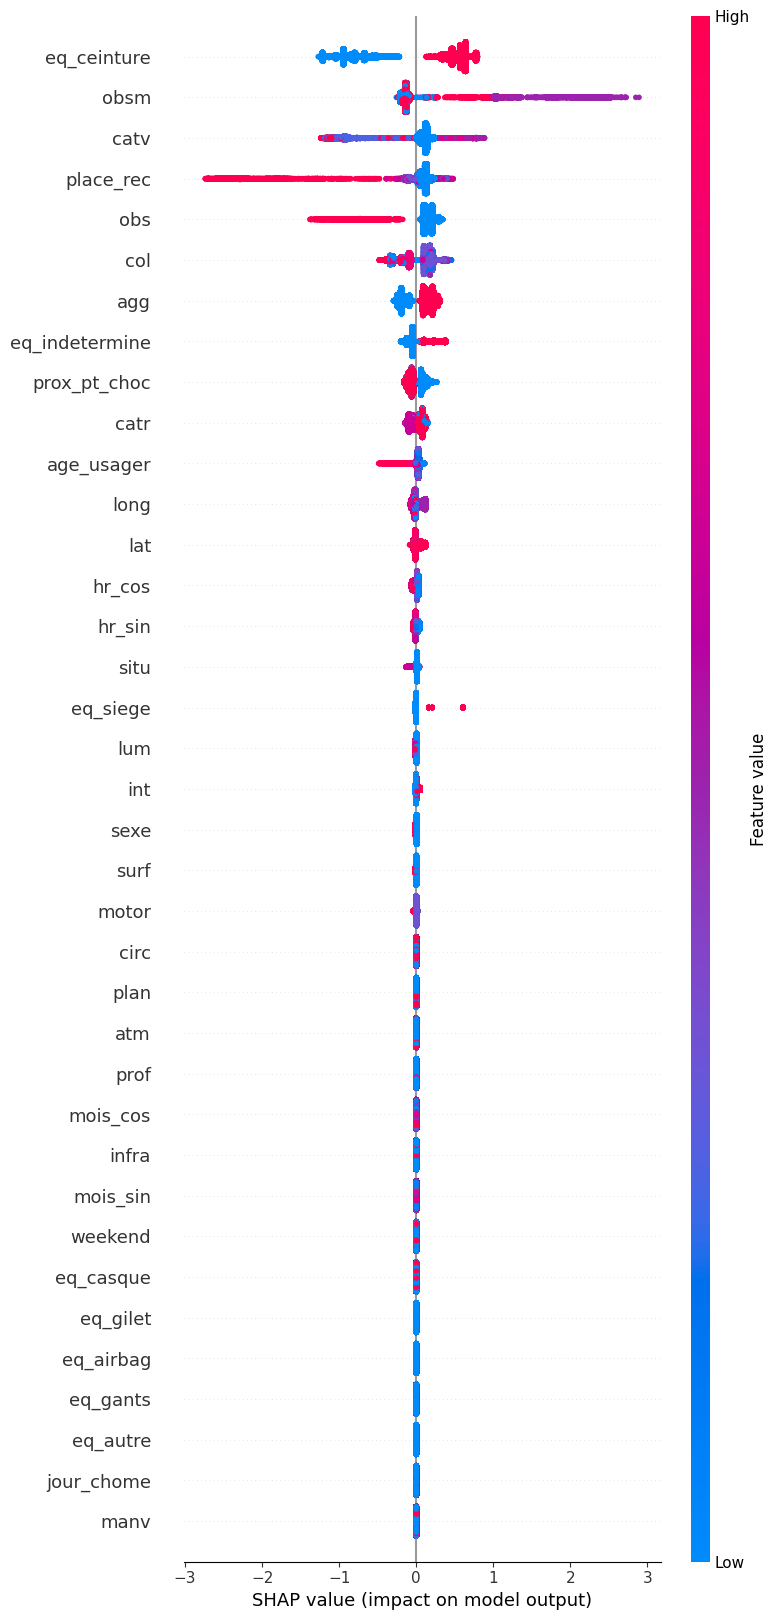

In [51]:
shap.summary_plot(shap_values[:, :, 0], X_test,max_display = len(X_test))